# Stoneburner, Kurt
- ## DSC 550 - Week6/7/8

Week 6/7/8 Work is included. Week08 content is towards the bottom of the document. I removed the tutorial/reference code to make my work easier to find. This assignement is getting rather lengthy.

I focused on brute force methods for choosing model attributes and the differences between modeling categorical variables as integers versus one-hot-encoded categorical variables.

For model evaluation, I examined the variability of random sampling in testing and training. Model scores varied by as much as .15 depending on the sample. My model evaluation approach was to run a model 1000 times, sort the models by score. I chose the test/train data set with the median score of the 1000 model runs. I see this as the middle ground between underfit & overfit random samples.

In [24]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yellowbrick

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)

#Install YellowBrick: conda install -c conda-forge yellowbrick

### Case Study:  Analyze data to predict who will Survive the Titanic ###
 
Load the data from the “train.csv” file into a DataFrame.
Display the dimensions of the file (so you’ll have a good idea the amount of data you are working with.
Display the first 5 rows of data so you can see the column headings and the type of data for each column.
   - Notice that Survived is represented as a 1 or 0
   - Notice that missing data is represented as “NaN”
   - The Survived variable will be the “target” and the other variables will be the “features”

In [25]:
#Step 1:  Load data into a dataframe
addr1 = "z_wk06_train.csv"
df = pd.read_csv(addr1)

In [26]:
#//*** Remove PassengerId
del df['PassengerId']
print(df.head(10))

   Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S
5         0       3                                   Moran, Mr. James    male   NaN      0      0            330877   8.4583   NaN        Q
6         0  

**Think about some questions that might help you predict who will survive:**

How does gender affect survival?

How does financial status (ie wealth) affect survival?

Is there a relationship between cabin and survival? This may be a proxy for wealth and survival though since the disaster unfolded over many hours.

Does age affect survival?

**What do the variables look like?**

**For example, are they numerical or categorical data.**

**If they are numerical, what are their distribution;**

**if they are categorical, how many are they in different categories?**

Categorical Variables:
 - PassengerId, Survived, Pclass, Name, Sex, SibSp, Parch, Ticket, Cabin, Emabrked
 
 Numerical Variables
 - Age, Fare

In [27]:
#//*** Build Lists of Numerical and Categorical Column names. Numerical Columns are easy and manually entered. Categoricals are the rest of the columns
numerical_cols = ['Fare','Age']
category_cols = []
for col in df.columns:
    if col not in numerical_cols:
        category_cols.append(col)

In [28]:
print("Unique Categorical Value Counts:")
for col in category_cols:
    print(f"{col}: {len(df[col].unique())}")

Unique Categorical Value Counts:
Survived: 2
Pclass: 3
Name: 891
Sex: 2
SibSp: 7
Parch: 7
Ticket: 681
Cabin: 148
Embarked: 4


The numerical values for Fare and Age are not normally distributed. The Majority of Fares on the Titanic were less than $50. While the majority of passenger are aged between 16-40.

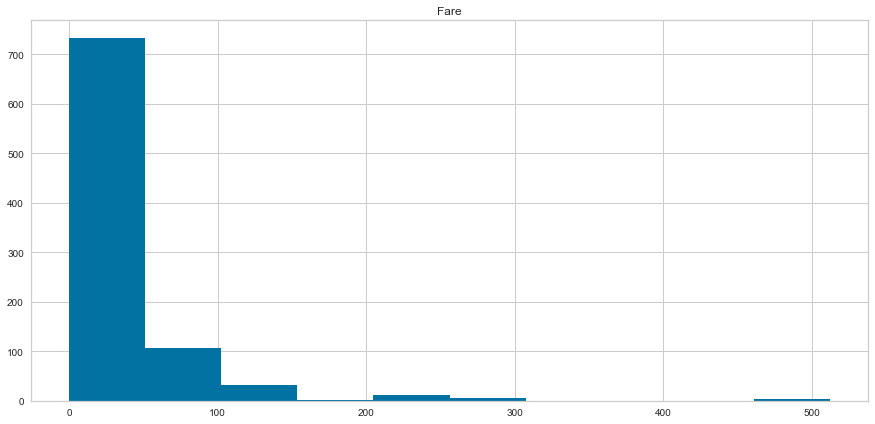

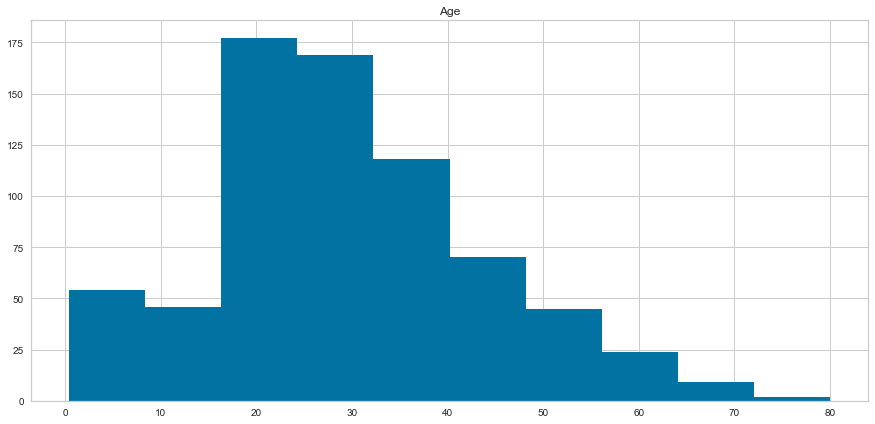

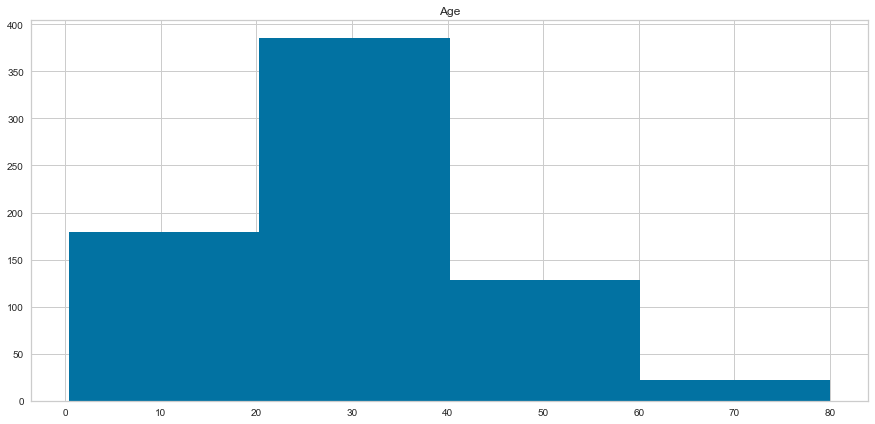

In [29]:
#//*** Use Pandas histogram feature to look at the distributions
for col in numerical_cols:
    df.hist(column=col)

#//*** Four bins shows the greatest cluster of ages
df.hist(column='Age', bins=4)
print()

Feature Creation
Convert text based categorical data to numerical catgegorical data.
- build sexcat (Sex Categorical)
   - values: 
       0. Male
       0. Female
- build embarkatcat (Embark Category)
    - values: 
        0. Southampton
        0. Cherbourg
        0. Queenstown
        0. NaN
- Build deck. Convert Cabin Value into a Deck Assignment. First Class (maybe 2nd) is assigned a cabin. Everyone else was in steerage. http://ssmaritime.com/Titanic-Deck-Plan.jpg

    - values:
        0. Z (Nan, assume Steerage/3rd Class)
        0. C Deck - Shelter Deck
        0. E Deck - Upper Deck
        0. G Deck - Lower Deck
        0. D Deck - Saloon Deck
        0. A Deck - Promenade Deck
        0. B Deck - Bridge Deck
        0. F Deck - Middle Deck
        0. T Deck - Unknown Deck, might be a miscode since it only applies to one entry


In [30]:
#//*** Convert Sex and Embark to Numerical value
#//*** Replace Sex values with a categorical integer. Build a dictionary of unique integers.
#//*** Enumerate generates a counter, value pair
#//*** tuple - places the counter value pair into a list of tuples
#//*** Dict converts the list of tuple pairs into a dictionary.

#//*** Only Convert if these fields are objects. This is to prevent re-running the code twice in iPython.
if (df.dtypes['Sex'] == object):
    sex_dict = dict(tuple(enumerate(df['Sex'].unique())))
    embark_dict = dict(tuple(enumerate(df['Embarked'].unique())))
    #print(sex_dict)
    #print(embark_dict)

    #//*** Build sexcat Categorical column
    df['sexcat'] = df['Sex'].copy()
    
    #//*** replace values using the sex_dict dictionary
    for key,value in sex_dict.items():
        df['sexcat'] = df['sexcat'].replace(value,key)

    #//*** Build the embarkation catergory column
    df['embarkcat'] = df['Embarked'].copy()
    
    #//*** replace values using the embark_dict dictionary
    for key,value in embark_dict.items():
        df['embarkcat'] = df['embarkcat'].replace(value,int(key))
        
    #//*** Convert the Cabin assignment to an integer based on desk assignment. This should correlate similarly with pclass.
    df['deck'] = df['Cabin'].copy()

    #//*** Assign NaN to ZZ
    df['deck'] = df['deck'].fillna("ZZ")
    
    #//*** The Deck assignment is the first letter of the Cabin assignment. Keep the first letter deck
    df['deck'] = df['deck'].apply(lambda x: x[0] )

    #//*** Build a dictionary of unique deck values
    deck_dict=dict(tuple(enumerate(df['deck'].unique())))
    
    #//*** Replace deck values using the deck_dict dictionary
    for key,value in deck_dict.items():
        df['deck'] = df['deck'].replace(value,key)
        
    #//*** Bin Ages into groups of every 5 years
    #//*** yr_bins is an array of 0-80 (max age) step 5
    yr_bins = np.array( range((int(df['Age'].max()/5))+1 ) ) *5

    #//*** df.cut() bins data based on yr_bins
    df['agebin'] = df['Age'].fillna(0).copy()
    df['agebin'] = pd.cut(df['agebin'],bins=yr_bins, labels=yr_bins[1:])



**Are the numerical variables correlated?**

Survival Correlates strongly with Gender (sexcat). There are moderate correlations with Fare and deck assignment

Age - Correlates with PClass (not with fare interestingly) and Sibling Spouse (SibSp). 
    - First Class is associated with older people
    - Sibling and Spouses (ie not single) is associated with younger people.

In [31]:
print("========================================================")
print("Correlations")
print("========================================================")
print(df.corr().replace(1,"*"))
print("========================================================")
print("Correlations Absolute Value > .25")
print("========================================================")
#Generate Correlations using absolute values to measure strength, replace 1 with 0 to hide self correlation
df_cors = df.corr().replace(1,0).abs()
#//*** Display all values with a weak Correlation .25 or Greater
print(df_cors[df_cors > .25 ].fillna("*") )

#//*** Build Dataframes for those who survived (or finsished as in fin_df) 
#//*** and for those who died (or did not finish as in dnf_df)
fin_df = df[ df['Survived'] == 1 ]
dnf_df = df[ df['Survived'] == 0 ]

#//*** [--= Gallows humour is a effect of spending 29 years in the news business. =--]
#//*** [--= I just realized I've been working in News for 29 YEARS!!!. That's a long time =--]

print("========================================================")
print("Survival Correlations")
print("========================================================")
df_cors = fin_df.corr().replace(1,0).abs()
print(df.corr().replace(1,"*"))
print("========================================================")
print("Correlations Absolute Value > .25")
print("========================================================")
print(df_cors[df_cors > .25 ].fillna("*") )

      


Correlations
            Survived     Pclass        Age      SibSp      Parch       Fare     sexcat  embarkcat       deck
Survived           *  -0.338481 -0.0772211 -0.0353225  0.0816294   0.257307   0.543351   0.118026    0.27031
Pclass     -0.338481          *  -0.369226  0.0830814  0.0184427    -0.5495    -0.1319   0.028566    -0.5628
Age       -0.0772211  -0.369226          *  -0.308247  -0.189119  0.0960667 -0.0932536  0.0315564   0.176955
SibSp     -0.0353225  0.0830814  -0.308247          *   0.414838   0.159651   0.114631 -0.0637943 -0.0545254
Parch      0.0816294  0.0184427  -0.189119   0.414838          *   0.216225   0.245489  -0.082144  0.0369444
Fare        0.257307    -0.5495  0.0960667   0.159651   0.216225          *   0.182333  0.0710096   0.376888
sexcat      0.543351    -0.1319 -0.0932536   0.114631   0.245489   0.182333          *   0.128526   0.114229
embarkcat   0.118026   0.028566  0.0315564 -0.0637943  -0.082144  0.0710096   0.128526          *  0.0466888
deck  

**Make some histograms of your data (“A picture is worth a thousand words!”)**

I'm answer most of these questions with histograms. Instead of choosing individual histograms to look at. Why Not look at all of them? I was inspired by DataFrame.hist() as a quick method to quickly look at data. I shifted to loops with MatPlotlib so I could create a color continuity that wasn't the ugly default colors.

**Are the distributions of numerical variables the same or different among survived and not survived? Is the survival rate different for different values? For example, were people more likely to survive if they were younger?**

Death distributions are varied across the categories. Let's start by looking at distributions of Survived and Died for all the numeric variables.

Survival (FIN) Distribution
Survived Distribution:Pclass


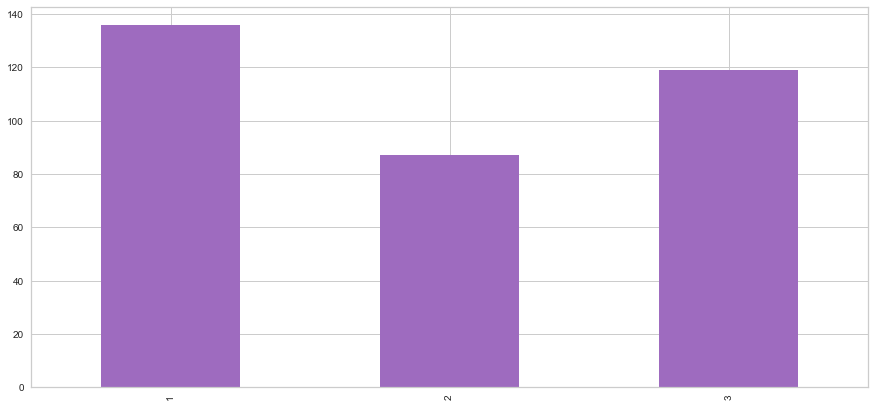

Survived Distribution:Sex


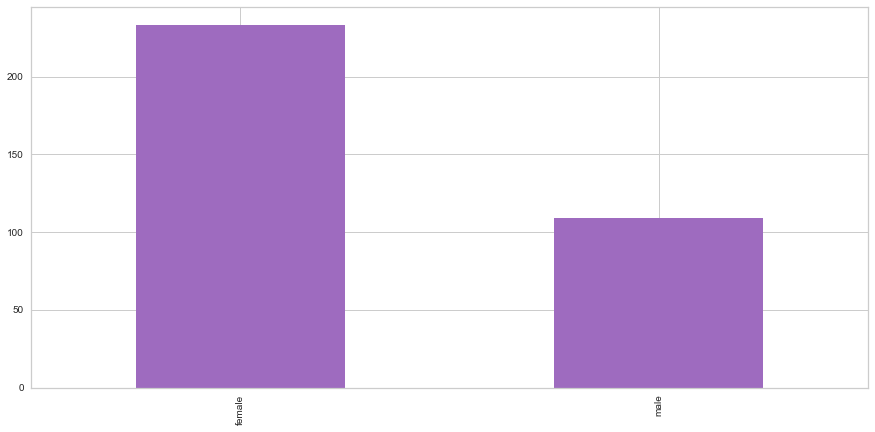

Survived Distribution:agebin


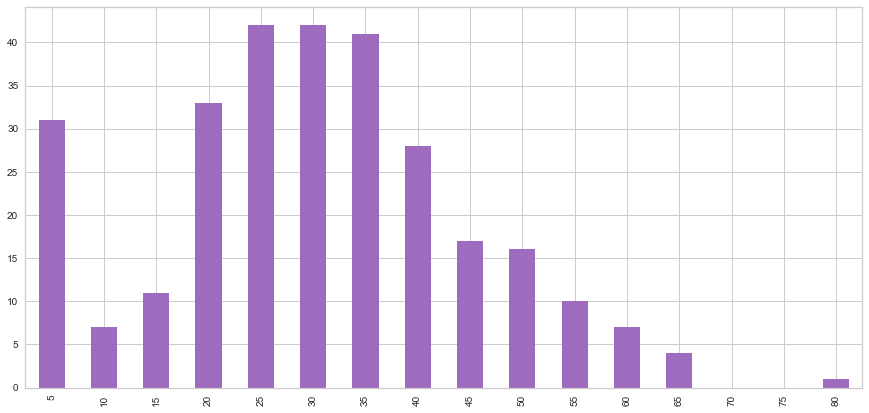

Survived Distribution:SibSp


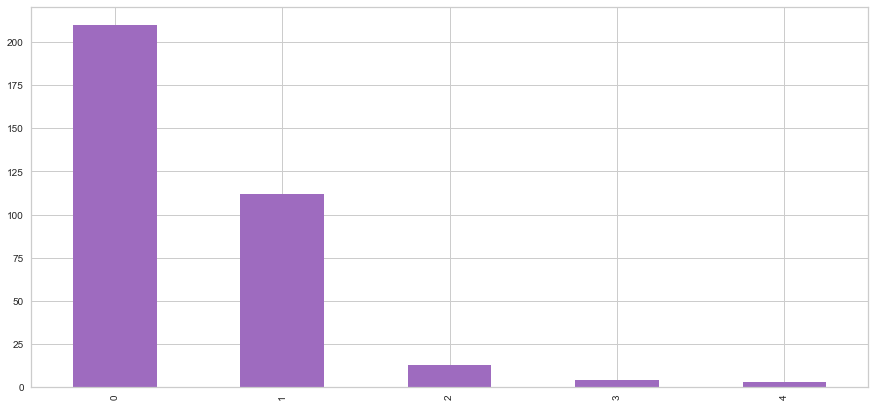

Survived Distribution:Embarked


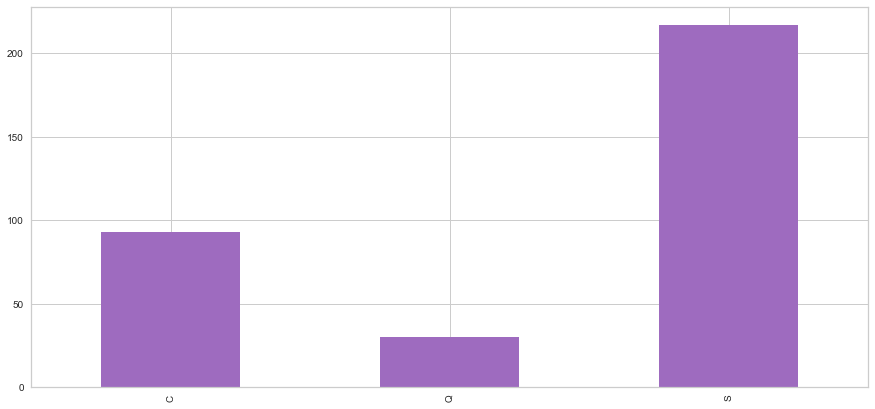

Survived Distribution:deck


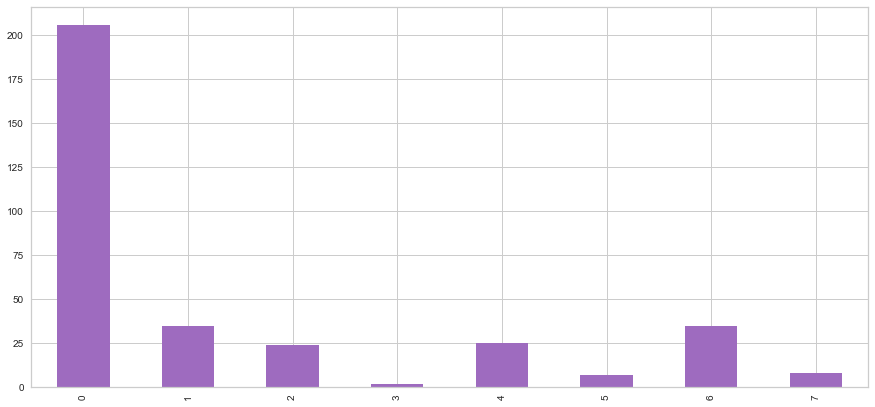

Survived Distribution:Parch


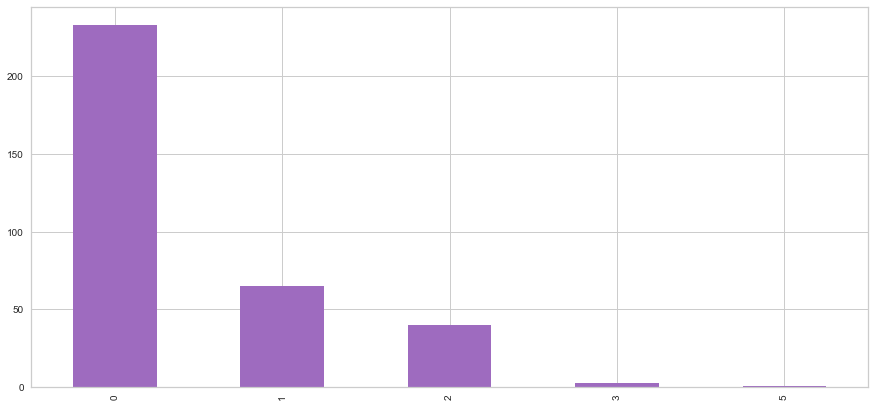

In [32]:
distrib_cols = ['Pclass','Sex','agebin','SibSp','Embarked','deck','Parch']

color_dict = {"survived" : "#9e6bbf","died" : "#7ba65e"}
print("==================================")
print("Survival (FIN) Distribution")
print("==================================")
#fin_df[distrib_cols].hist()
#print()
for cols in distrib_cols:
    print('Survived Distribution:' + cols)
    fin_df[cols].value_counts().sort_index().plot(kind='bar', color=color_dict["survived"])
    plt.show()

Death (DNF) Distribution
Deaths Distribution:Pclass


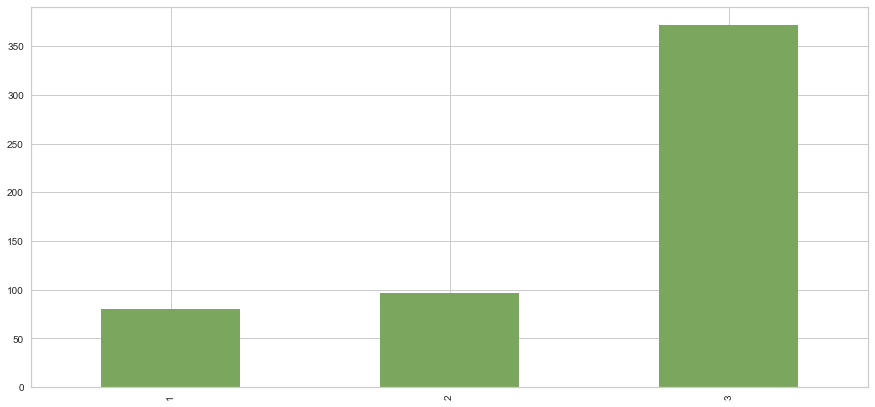

Deaths Distribution:Sex


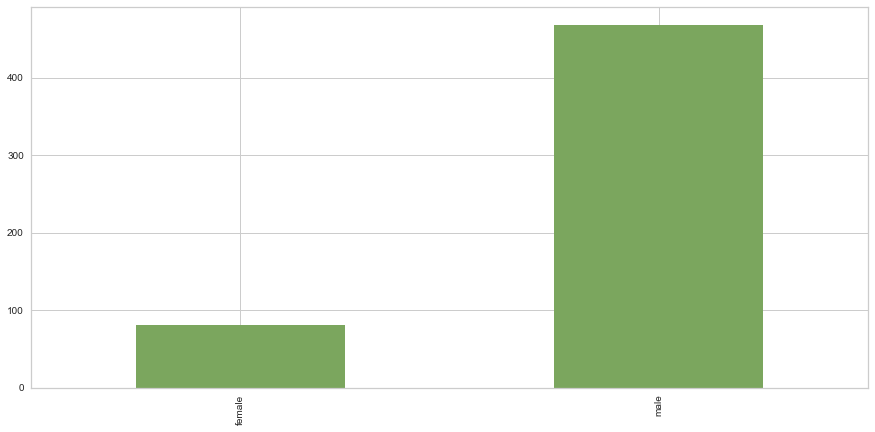

Deaths Distribution:agebin


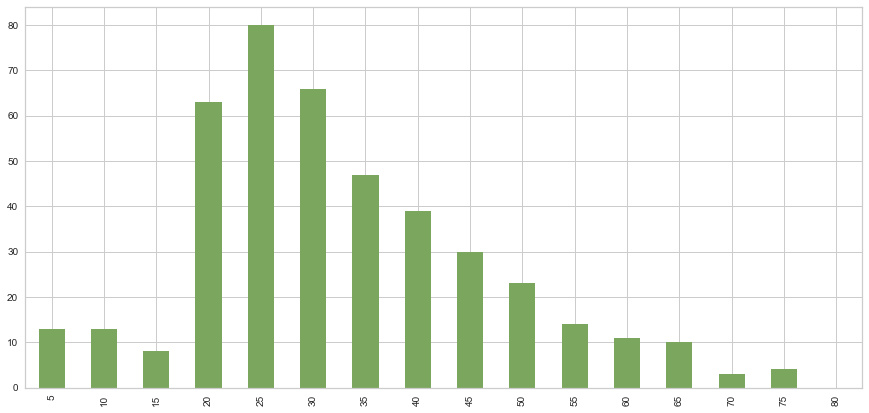

Deaths Distribution:SibSp


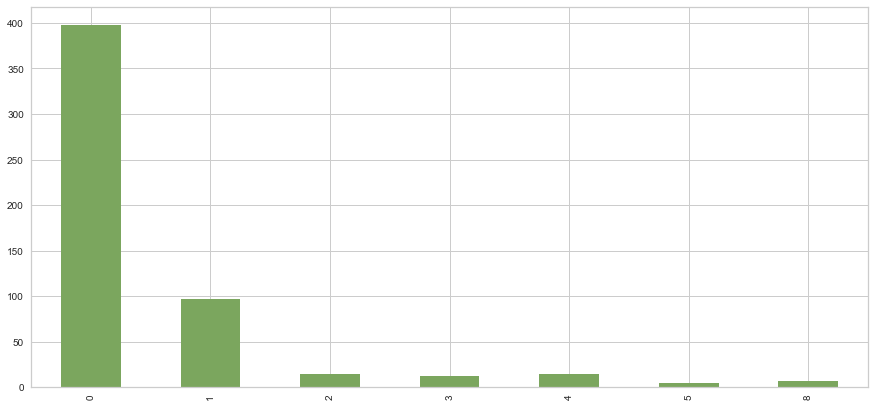

Deaths Distribution:Embarked


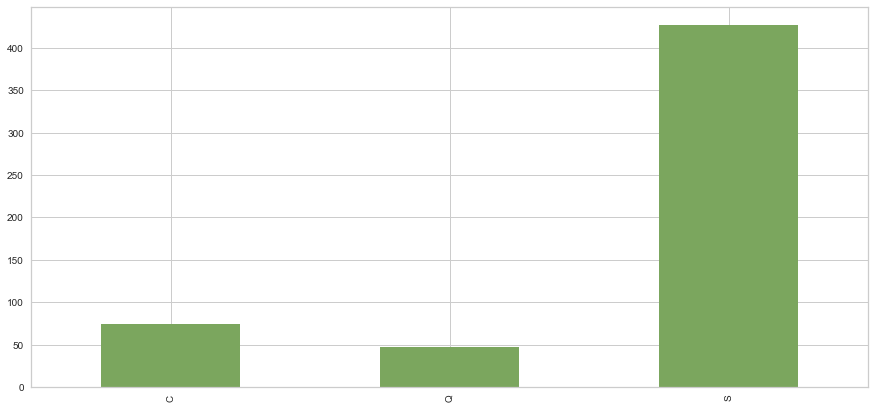

Deaths Distribution:deck


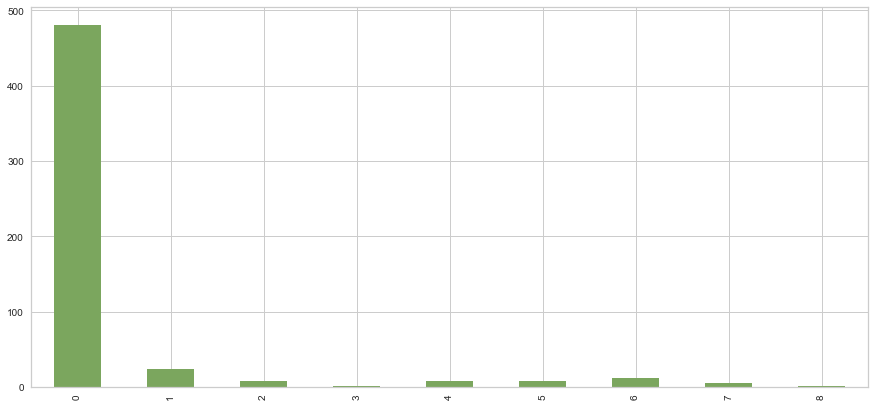

Deaths Distribution:Parch


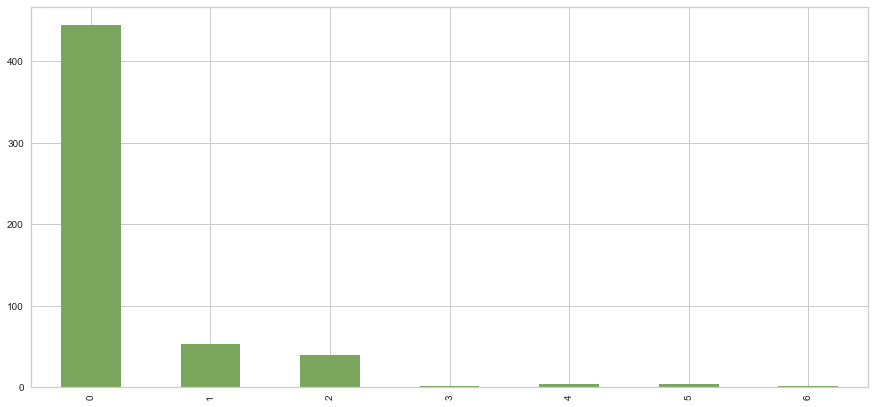

In [33]:
print("==================================")
print("Death (DNF) Distribution")
print("==================================")
#dnf_df[distrib_cols].hist()

for cols in distrib_cols:
    print('Deaths Distribution:' + cols)
    dnf_df[cols].value_counts().sort_index().plot(kind='bar',color=color_dict["died"])
    plt.show()

**Are there different survival rates in different categories? For example, did more women survived than man?**

We can look at the distributions as a stacked barchart portraying the Survivability Percentage for each category.

Examples:
    - Women 76% Survival
    - First Class: 62% Survival
    - 80 Years old: 100% Survival
    - Cabins on deck 2, 4, 6: 77% Survival
   

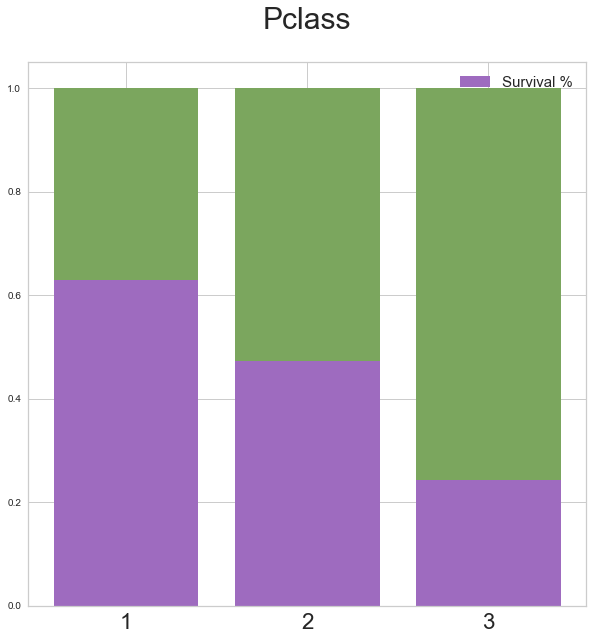

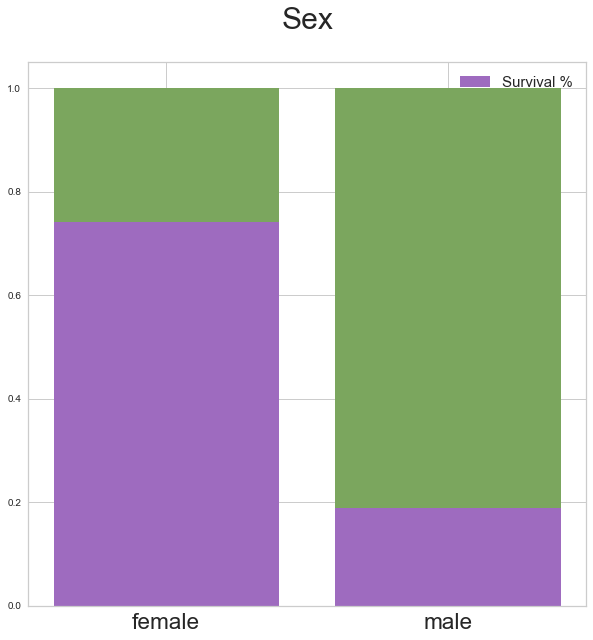

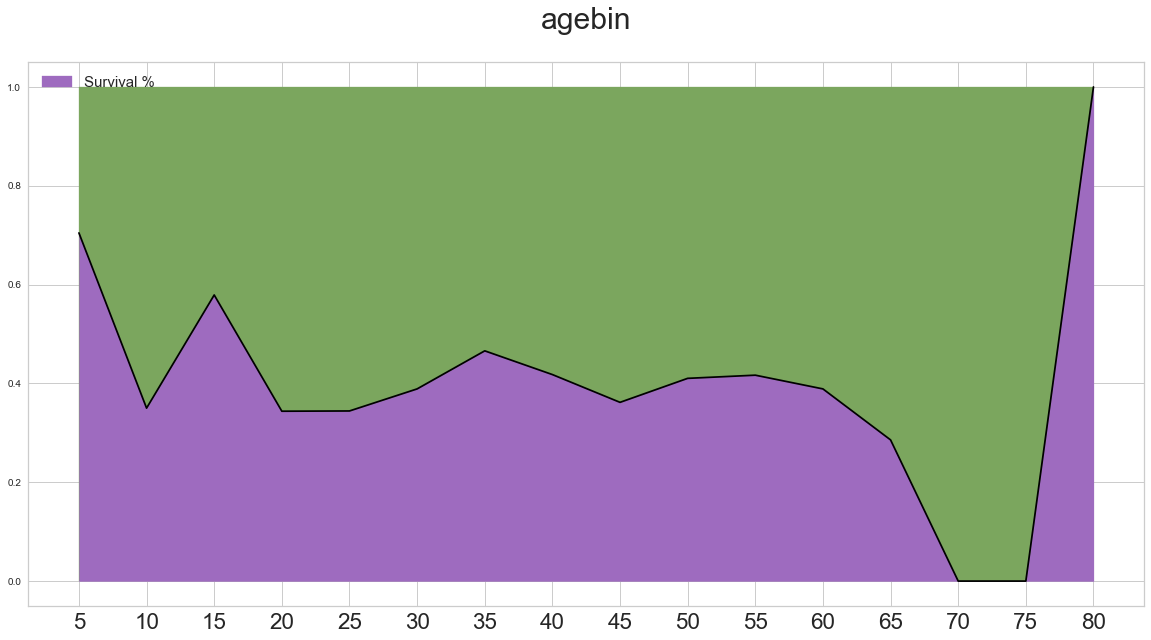

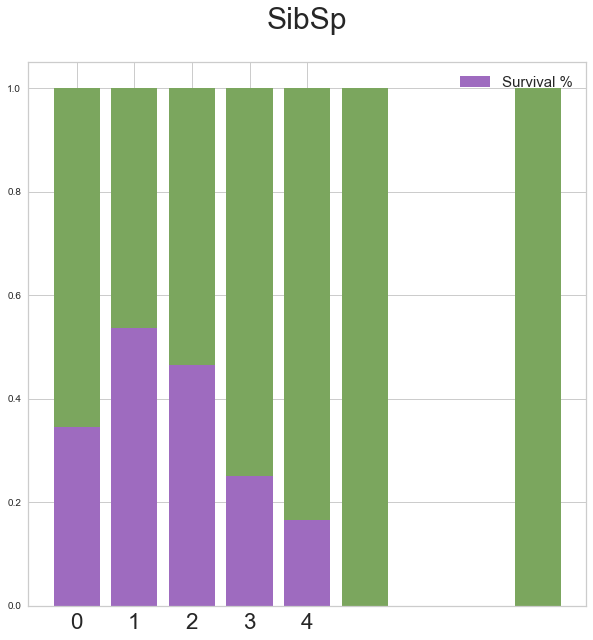

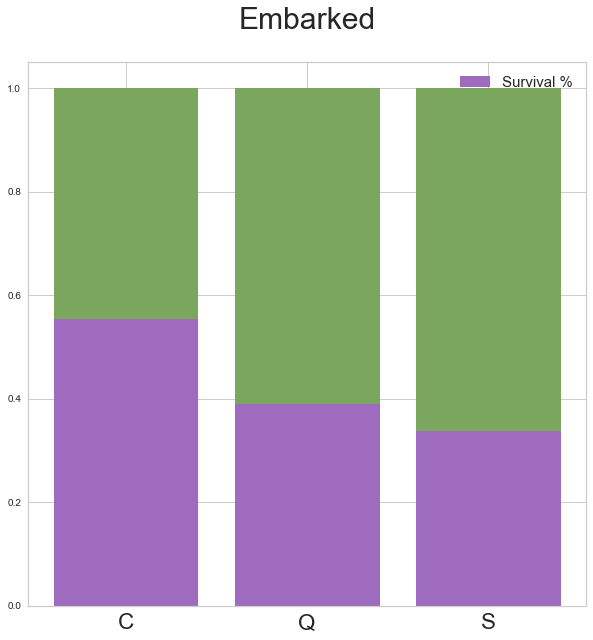

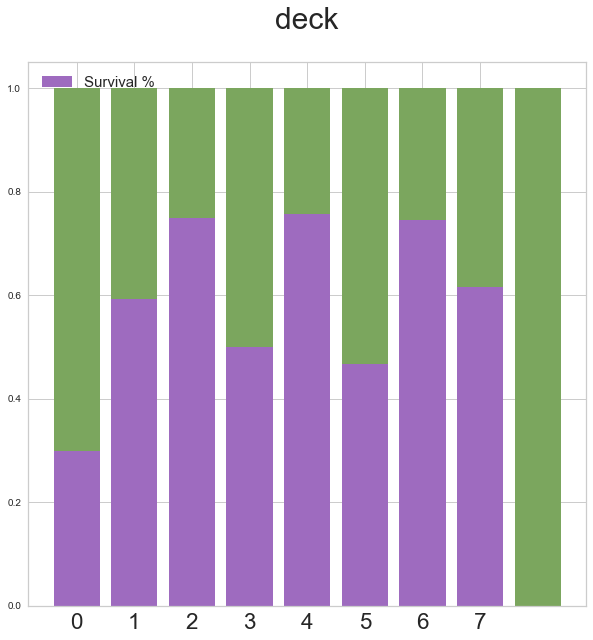

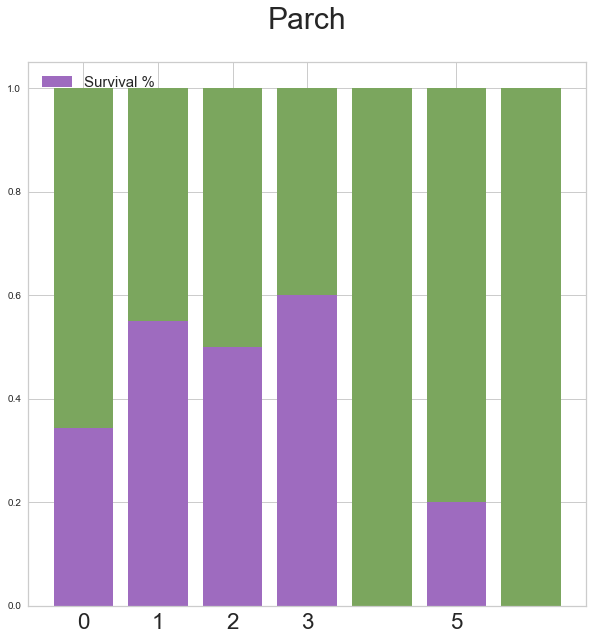

In [34]:
#//*** Display the Survival Percentages for each Column/Value

for cols in distrib_cols:
    
    #//*** Survived DF
    spmf = (fin_df[cols].value_counts().sort_index())
    
    #//*** All Passengers
    dpmf = (df[cols].value_counts().sort_index())
    

    #//*** Font value to apply across the plot
    bar_font_size = 30

    #//*** Somewhat arbitrary value of the display Bar width
    bar_width = .35
    
    #//*** Define Subplots
    if cols == 'agebin':
        fig, ax = plt.subplots(figsize=(20, 10))
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        
    
    
    if cols == 'agebin':
        #//**** Draw 1 as in 100% as a background to create the illusion of stacked bar charts to highlight survival chances by category
        #plt.plot((spmf/dpmf).index, 1, color=color_dict["died"])

        #//**** Draw the percentage of survival for eac category
        plt.fill_between((spmf/dpmf).index, 1, color=color_dict["died"])
        plt.fill_between((spmf/dpmf).index, spmf/dpmf, label='Survival %', color=color_dict["survived"])
        plt.plot((spmf/dpmf).index, spmf/dpmf, color="black")
        #plt.fill_between((spmf/dpmf).index, spmf/dpmf,color='g',alpha=.5)
    else:
        #//**** Draw 1 as in 100% as a background to create the illusion of stacked bar charts to highlight survival chances by category
        plt.bar((spmf/dpmf).index, 1, color=color_dict["died"])

        #//**** Draw the percentage of survival for eac category
        plt.bar((spmf/dpmf).index, spmf/dpmf, label='Survival %', color=color_dict["survived"])

    plt.title(cols,fontsize=bar_font_size,y=1.05)
    
    #//*** Label the X axis. Replaces the index values with the labels in the ethnic list.
    plt.xticks(spmf.index,fontsize=bar_font_size*.75)

    #plt.yticks(fontsize=bar_font_size*.75)

    #//*** Label the Y axis
    #plt.ylabel("New Cases per 100k", fontsize=bar_font_size)

    #//*** Draw the Legend
    plt.legend(fontsize=bar_font_size*.5)

    #//*** Display the Graph
    plt.show()



**Look at summary information about your data (total, mean, min, max, freq, unique, etc.)  Does this present any more questions for you?  Does it lead you to a conclusion yet?**

I reinforces what the distribution graphs reflect. The mean age for the survived is less than the mean overall. The Fare of survivors was higher than the mean overall with a much higher standard deviation. Being wealthy increased the survival chances. No big secret there.

In [35]:
print(df.describe())
print(fin_df.describe())
print(dnf_df.describe())

#age class fare 

         Survived      Pclass         Age       SibSp       Parch        Fare      sexcat   embarkcat        deck
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208    0.352413    0.368126    0.811448
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429    0.477990    0.647601    1.815143
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400    0.000000    0.000000    0.000000
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200    0.000000    0.000000    0.000000
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000    1.000000    1.000000    0.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200    1.00000

**Most of the passengers are around 20 to 30 years old and don't have siblings or relatives with them. A large amount of the tickets sold were less than \\$50. There are very few tickets sold where the fare was over \\$500.**

**Make some bar charts for variables with only a few options.**

- **Ticket and Cabin have more than 100 variables so don’t do those!**

I did reduce the cabins to their deck assignments which was interesting.
Here are more bar graphs as PMFs.

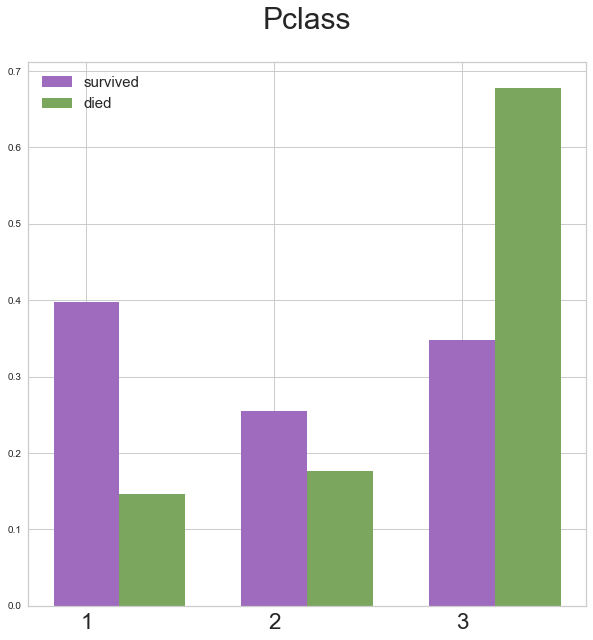

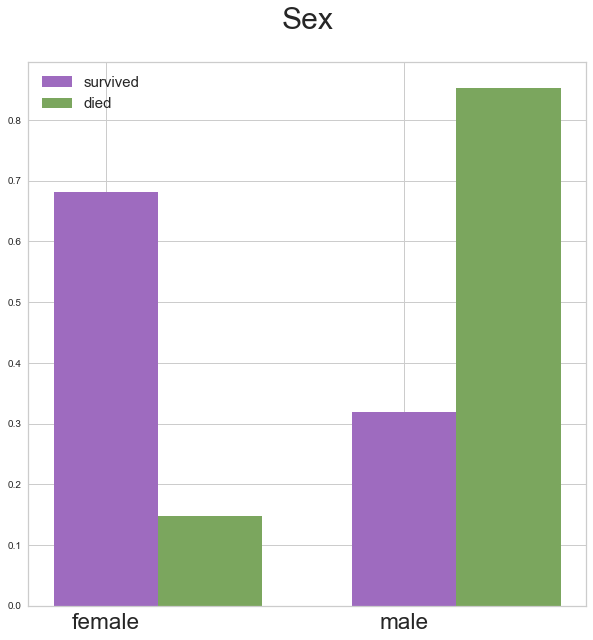

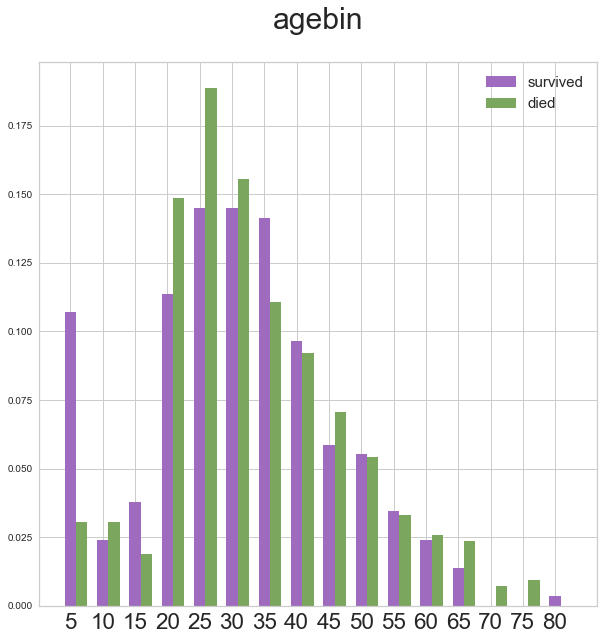

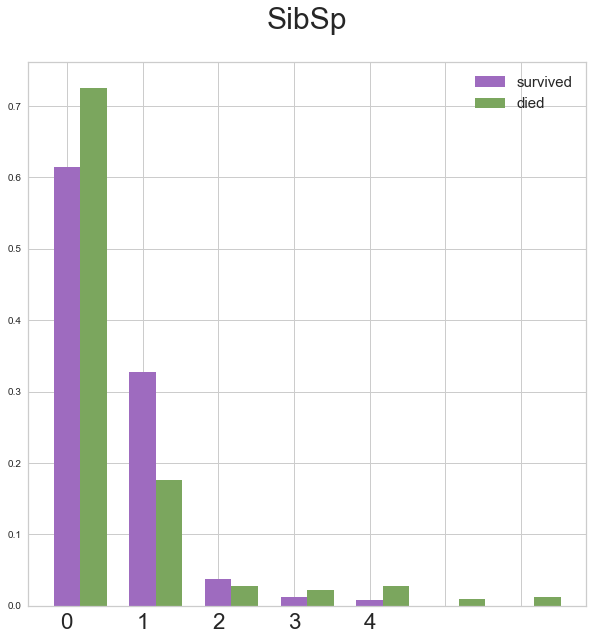

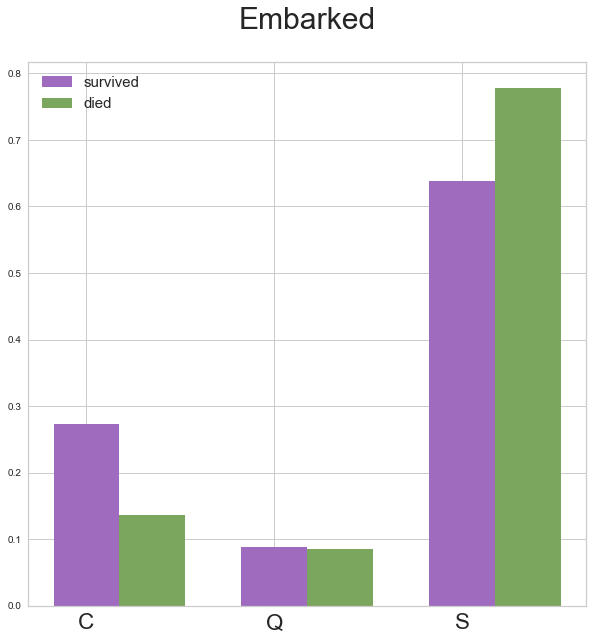

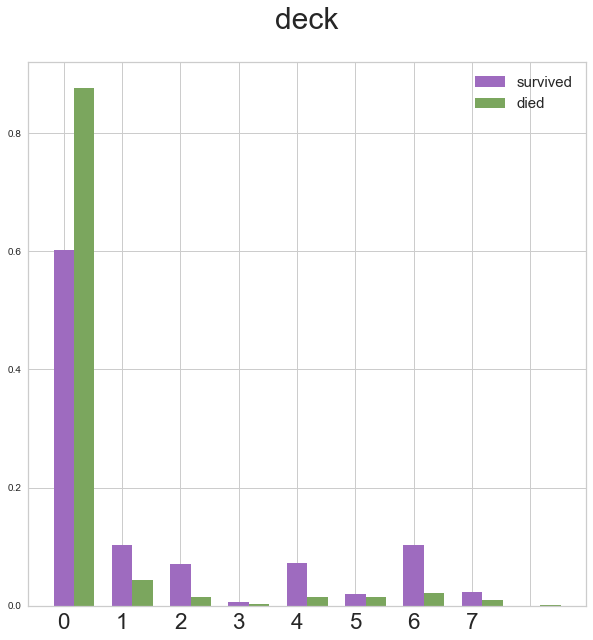

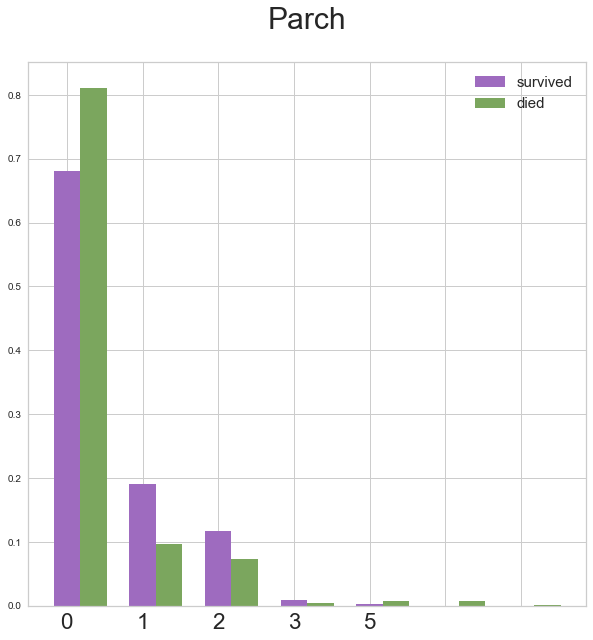

In [36]:
#//**************************************************************
#//*** View the distributions as Probability mass function
#//**************************************************************
# //*****************************************
# // This code came straight from DSC  530!!!
# //*****************************************
# //*** Build a probability mass function
# //*****************************************
# //*** Returns Series as a PMF
# //*****************************************
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        output_series.loc[value] = freq/total_values
    return output_series

for cols in distrib_cols:
    
    spmf = build_pmf(fin_df[cols].value_counts().sort_index())
    dpmf = build_pmf(dnf_df[cols].value_counts().sort_index())
    
    #//*** Index is Used as an offset value which is used to draw the individual bar graphs
    #index = np.arange(len(ethnic)-1)

    #//*** Font value to apply across the plot
    bar_font_size = 30

    #//*** Somewhat arbitrary value of the display Bar width
    bar_width = .35

    #//*** Define Subplots
    fig, ax = plt.subplots(figsize=(10, 10))
    
    index = np.arange(len(dpmf))
    index2 = np.arange(len(spmf))
    
    
    #//*** Draw the Actual Values
    #//*** X = Index which is a range 1 - 5
    #//*** Y = Actual Case Values per 100k
    #//*** Bar Width (How Wide to draw)
    #//*** Color = List based color palette
    #//*** Note: No Labels, we don't want the ethnicity to be drawn in the legend
    plt.bar(index2,spmf, bar_width, label='survived',color=color_dict["survived"])
    plt.bar(index+bar_width ,dpmf, bar_width, label='died', color=color_dict["died"])

    #//*** Draw the Expected Values
    #//*** X = Index + a multiple of the bar width. The multiple is to account for different sized bar widths
    #//*** Y = Expected Case Values per 100k
    #//*** Multiple of Bar Width (How much smaller to draw the bar)
    #//*** Color = Hardcoded to black, with an alpha of .55 to make it gray(ish)
    #//*** Label = Only one label for the Legend
    #plt.bar(index+bar_width/1.35,expected_cases[1:], bar_width/2,color= 'black',alpha=.55,label='Expected Cases')

    plt.title(cols,fontsize=bar_font_size,y=1.05)

    try:
        #//*** Label the X axis. Replaces the index values with the labels in the ethnic list.
        plt.xticks(index,spmf.index,fontsize=bar_font_size*.75)
    except:
        plt.xticks(spmf.index,fontsize=bar_font_size*.75)
    #plt.yticks(fontsize=bar_font_size*.75)

    #//*** Label the Y axis
    #plt.ylabel("New Cases per 100k", fontsize=bar_font_size)

    #//*** Draw the Legend
    plt.legend(fontsize=bar_font_size*.5)

    #//*** Display the Graph
    plt.show()




**To see if the data is correlated, make some Pearson Ranking charts**

**The correlation between the variables is low (1 or -1 is high positive or high negative, 0 is low or no correlation)  These results show there is “some” positive correlation but it’s not a high correlation.**

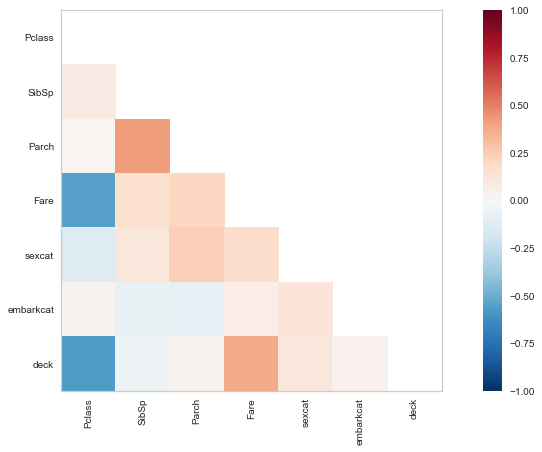

In [37]:
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['Pclass','SibSp','Parch','Fare','sexcat','embarkcat','deck']
# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
plt.show()

**Use Parallel Coordinates visualization to compare the distributions of numerical variables between passengers that survived and those that did not survive.**
**That’s a cool chart, isn’t it?!  Passengers traveling with siblings on the boat have a higher death rate and passengers who paid a higher fare had a higher survival rate.**

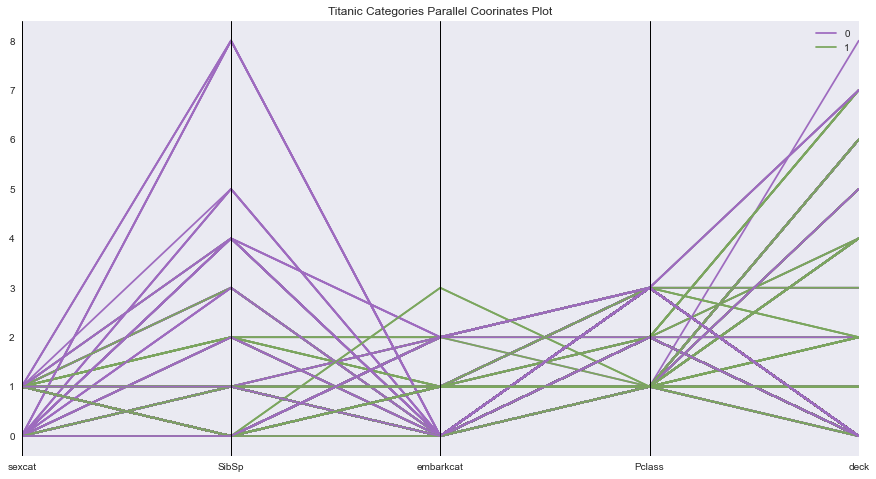

In [38]:
num_features = ['sexcat','SibSp','embarkcat','Pclass','deck']

with plt.style.context(("ggplot", "seaborn")):
    fig = plt.figure(figsize=(15,8))
    pd.plotting.parallel_coordinates(df, "Survived",
                                     cols=num_features,
                                     color=[color_dict['survived'],color_dict['died']],
                                     #alpha=0.3,
                                     #axvlines_kwds={"color":"red"})
                                    )
    #plt.xticks(rotation=90)
    plt.title("Titanic Categories Parallel Coorinates Plot")

Use Stack Bar Charts to compare passengers who survived to passengers who didn’t survive based on the other variables.
More females survived than men.  3rd Class Tickets had a lower survival rate.  Also, Embarkation from Southampton port had a lower survival rate.

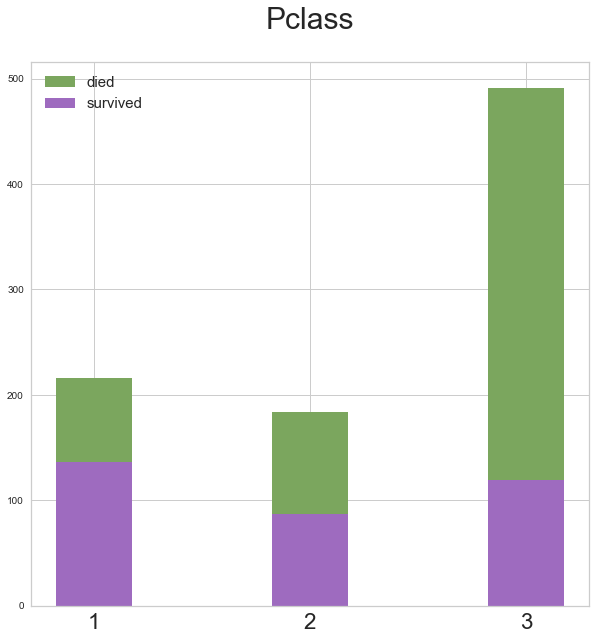

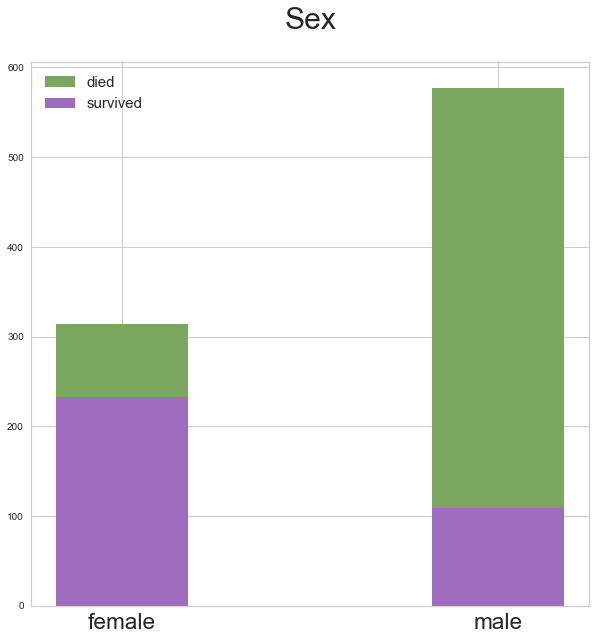

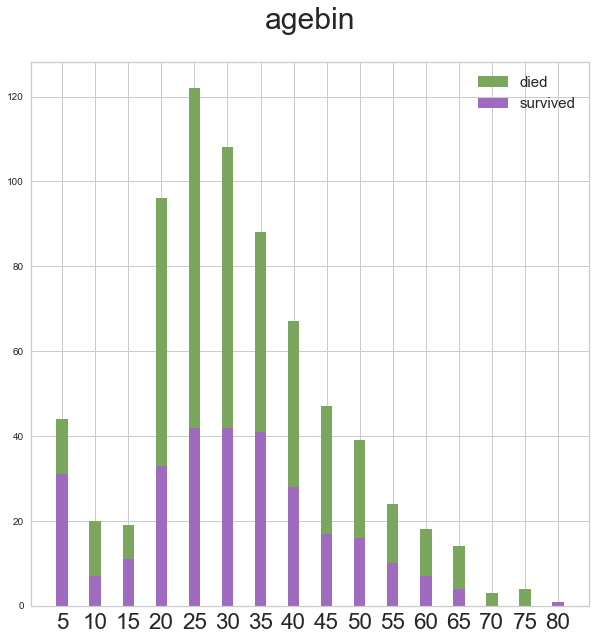

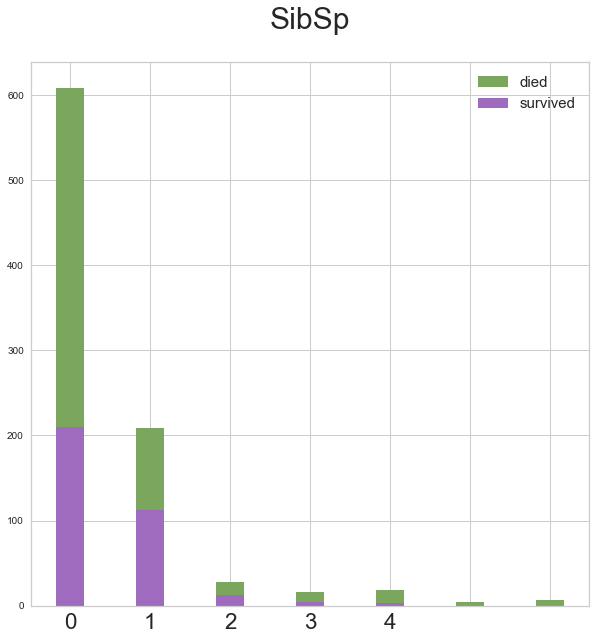

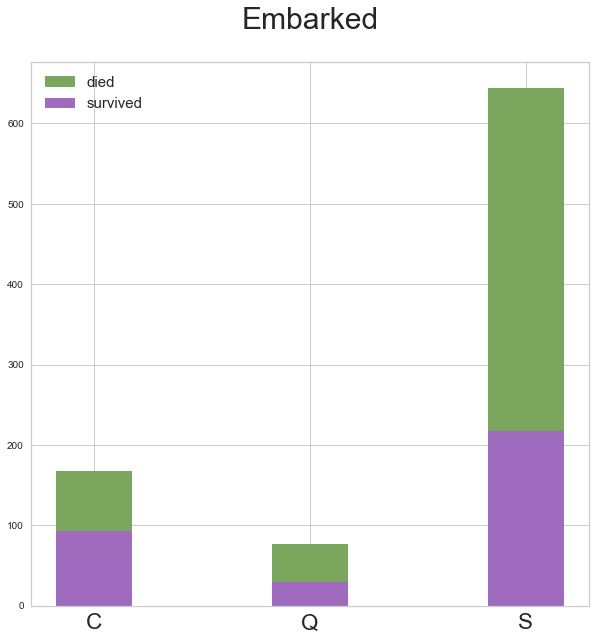

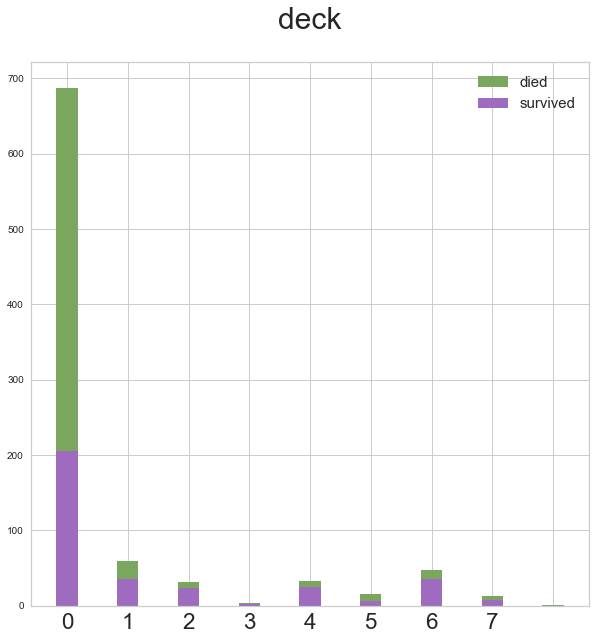

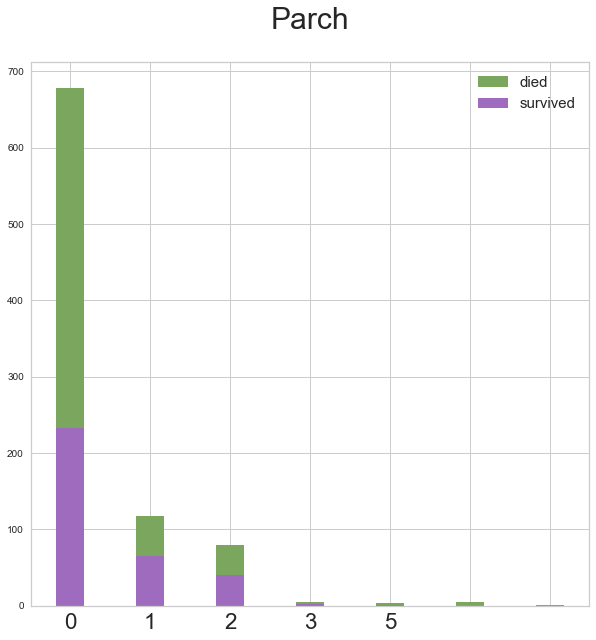

In [39]:
#//**************************************************************
#//*** View the distributions as Probability mass function
#//**************************************************************
#//*** Technically these aren't stacked bar charts which would use the bottom value.
#//*** Since these are essentially percentages I'm drawing the survived values over the total passenger numbers
#//*** It's inelegant, but it works.
# //*****************************************
# // This code came straight from DSC  530!!!
# //*****************************************
# //*** Build a probability mass function
# //*****************************************
# //*** Returns Series as a PMF
# //*****************************************
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        output_series.loc[value] = freq/total_values
    return output_series

for cols in distrib_cols:
    
    spmf = (fin_df[cols].value_counts().sort_index())
    dpmf = (df[cols].value_counts().sort_index())
    
    #//*** Index is Used as an offset value which is used to draw the individual bar graphs
    #index = np.arange(len(ethnic)-1)

    #//*** Font value to apply across the plot
    bar_font_size = 30

    #//*** Somewhat arbitrary value of the display Bar width
    bar_width = .35

    #//*** Define Subplots
    fig, ax = plt.subplots(figsize=(10, 10))
    
    index = np.arange(len(dpmf))
    index2 = np.arange(len(spmf))
    
    
    #//*** Draw the Actual Values
    #//*** X = Index which is a range 1 - 5
    #//*** Y = Actual Case Values per 100k
    #//*** Bar Width (How Wide to draw)
    #//*** Color = List based color palette
    #//*** Note: No Labels, we don't want the ethnicity to be drawn in the legend
    plt.bar(index ,dpmf, bar_width, label='died', color=color_dict["died"])
    plt.bar(index2,spmf, bar_width, label='survived',color=color_dict["survived"])


    #//*** Draw the Expected Values
    #//*** X = Index + a multiple of the bar width. The multiple is to account for different sized bar widths
    #//*** Y = Expected Case Values per 100k
    #//*** Multiple of Bar Width (How much smaller to draw the bar)
    #//*** Color = Hardcoded to black, with an alpha of .55 to make it gray(ish)
    #//*** Label = Only one label for the Legend
    #plt.bar(index+bar_width/1.35,expected_cases[1:], bar_width/2,color= 'black',alpha=.55,label='Expected Cases')

    plt.title(cols,fontsize=bar_font_size,y=1.05)

    #//*** Label the X axis. Replaces the index values with the labels in the ethnic list.
    try:
        plt.xticks(index,spmf.index,fontsize=bar_font_size*.75)
    except:
        plt.xticks(index,dpmf.index,fontsize=bar_font_size*.75)
    #plt.yticks(fontsize=bar_font_size*.75)

    #//*** Label the Y axis
    #plt.ylabel("New Cases per 100k", fontsize=bar_font_size)

    #//*** Draw the Legend
    plt.legend(fontsize=bar_font_size*.5)

    #//*** Display the Graph
    plt.show()




**Part 2:  Complete this tutorial (Steps 11-13) and then use what you learn to create your own case study.
The data set is available in Weekly Resources/Data**

**11.	Some of my questions have been answered by seeing the charts but in some ways, looking at this much data has created even more questions.**
    
   - **a. We can also fill in missing values.  (Cabin has some missing values but we are dropping that feature.)  Age has some missing values so I’ll fill in with the average age.  Embarked also has some missing so I’ll the most common.)**

In [40]:
#//*** Are NaN Cabins appropriately Classified as Deck 0 Steerage?
#//*** Get all 3rd Class Passengers
tdf =df[df['Pclass'] == 3 ]

#//*** Displat count of 3rd Class Passengers
print(f"Total 3rd Class Cabins: {len(tdf)}")

#//*** Get Count of Passengers without Cabin assignment
tdf = len(tdf[tdf['Cabin'].isna()])

#The Majority of 3rd Class didn't have a Cabin Assignment. Categorizing Cabin NaN as Deck 0 (steerage is appropriate)
print(f"3rd Class NaN Cabins: {tdf}")

Total 3rd Class Cabins: 491
3rd Class NaN Cabins: 479


In [41]:
print(f"There are {len(df[ df['Embarked'].isna()])} NaN values. Will replace these with the most common value")

#//**** Get the most common value. We know it is S, but let's do this programatically.
mostCommon = 0
mostValue = ""
#//*** Loop through unique values
for value in df["Embarked"].unique():
    
    #//*** Get count of unique Values
    if len(df[ df["Embarked"] == value]) > mostCommon:
        
        #//*** Assign most common values
        mostCommon = len(df[ df["Embarked"] == value])
        mostValue = value

print(f"Most Common: {mostCommon} {mostValue}" )

#//*** Replace Embarked NaN with most common value
df["Embarked"] = df["Embarked"].fillna(mostValue)

#//*** Replace embarkcat 3 with most common value
for key,value in embark_dict.items():
    if value == mostValue:
        df['embarkcat'] = df['embarkcat'].replace(3,key)

#//*** Verify Embarked and embarkcat cleaning        
print(f"There are {len(df[ df['Embarked'].isna()])} Embarked NaN values.")    
print(f"There are {len(df[ df['embarkcat'] == 3])} embarkcat 3 Values")    

There are 2 NaN values. Will replace these with the most common value
Most Common: 644 S
There are 0 Embarked NaN values.
There are 0 embarkcat 3 Values


In [42]:
#//*** Replace NaN Age with the Mean Age
print(f"Mean Age: {df['Age'].mean()}")

print(f"Total Missing Ages: {df['Age'].isna().sum()}")
df['Age'] = df['Age'].fillna(df['Age'].mean())
print(f"Remaining NaN Values: {df['Age'].isna().sum()}")

#//*** Adjust the agebin of NaN to 25
df['agebin'] = df['agebin'].fillna(25)



Mean Age: 29.69911764705882
Total Missing Ages: 177
Remaining NaN Values: 0


**b.	Now it’s time to reduce some of the features so we can concentrate on the things that matter!  There features we will get rid of are:  "PassengerId", "Name", "Ticket" and "Cabin".  (ID doesn’t really give us any useful data, Ticket and Cabin have too many variables.  Name might reflect that they are related but we’re keeping the category about siblings (for now).**

    - Remove Cabin
    - Remove Ticket
    - Remove Name
    - Remove Embarked
    - Remove Sex

In [43]:
#//*** Remove Columns in this list to reduce features
removeCols = ["Name","Cabin","Ticket","Embarked","Sex"]

for col in removeCols:
    
    #//*** Verify Column exists, this handles iPython issues
    if col in df.columns:
        del df[col]
print(df)


     Survived  Pclass        Age  SibSp  Parch     Fare  sexcat  embarkcat  deck agebin
0           0       3  22.000000      1      0   7.2500       0        0.0     0     25
1           1       1  38.000000      1      0  71.2833       1        1.0     1     40
2           1       3  26.000000      0      0   7.9250       1        0.0     0     30
3           1       1  35.000000      1      0  53.1000       1        0.0     1     35
4           0       3  35.000000      0      0   8.0500       0        0.0     0     35
..        ...     ...        ...    ...    ...      ...     ...        ...   ...    ...
886         0       2  27.000000      0      0  13.0000       0        0.0     0     30
887         1       1  19.000000      0      0  30.0000       1        0.0     6     20
888         0       3  29.699118      1      2  23.4500       1        0.0     0     25
889         1       1  26.000000      0      0  30.0000       0        1.0     1     30
890         0       3  32.000000

**12.	 If you go back and look at the histograms of Fare, you’ll see that it is very skewed...many low cost fares, not very many high cost fares. Log Transformation is a good method to use on highly skewed data.**

I noticed several divide by zero errors when performing a log transform. It looks like there were some 0$ Fares. Since the fares are highly skewed, I decided to replace the missing 1st, 2nd and 3rd Class Fares with the Median values of each class respectively. This was trickier than I expected since I kept generating Pandas warnings. The solution was to make a coopy of the Fare Series, modify the Fares then copy the updated Fares back to the original dataframe.

In [44]:
#//*** There are missing Fares. Replace the Fares with the Median value of their respective fares.
median_fare_1st_class = df[ df['Pclass']==1 ]['Fare'].median()
median_fare_2nd_class = df[ df['Pclass']==2 ]['Fare'].median()
median_fare_3rd_class = df[ df['Pclass']==3 ]['Fare'].median()


#//*** Make a copy of the Fares Series. Avoids Pandas Warnings
tempFare = df['Fare'].copy()

#//*** Get Indexes of 3rd Class 0 Fares
for index in df.query("Pclass == 3 & Fare == 0").index:
    #//*** Replace the value at each index.
    tempFare.loc[index] = median_fare_3rd_class

#//*** Get Indexes of 2nd Class 0 Fares
for index in df.query("Pclass == 2 & Fare == 0").index:
    #//*** Replace the value at each index.
    tempFare.loc[index] = median_fare_2nd_class

#//*** Get Indexes of 1st Class 0 Fares
for index in df.query("Pclass == 1 & Fare == 0").index:
    #//*** Replace the value at each index.
    tempFare.loc[index] = median_fare_1st_class

#//*** Copy the Fare back into the dataframe.
df['Fare'] = tempFare.copy()

#//*** Add logfare column which is a log() of the Fare Column
df['logfare'] = np.log(df['Fare'])

#https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

**13.	 Convert your categorical data into numbers (Sex, PClass, Embark)**

I converted to categorical values last week at step 3.

- sexcat - Categorical Gender (Male Female)

- embarkcat - Categorical Embarkation

- agebin - Binned the ages into multiples of 5.

- deck - Converted the Cabin Assignments

In [45]:
print(df)

     Survived  Pclass        Age  SibSp  Parch     Fare  sexcat  embarkcat  deck agebin   logfare
0           0       3  22.000000      1      0   7.2500       0        0.0     0     25  1.981001
1           1       1  38.000000      1      0  71.2833       1        1.0     1     40  4.266662
2           1       3  26.000000      0      0   7.9250       1        0.0     0     30  2.070022
3           1       1  35.000000      1      0  53.1000       1        0.0     1     35  3.972177
4           0       3  35.000000      0      0   8.0500       0        0.0     0     35  2.085672
..        ...     ...        ...    ...    ...      ...     ...        ...   ...    ...       ...
886         0       2  27.000000      0      0  13.0000       0        0.0     0     30  2.564949
887         1       1  19.000000      0      0  30.0000       1        0.0     6     20  3.401197
888         0       3  29.699118      1      2  23.4500       1        0.0     0     25  3.154870
889         1       

# BEGIN Week 08 #

**14. Training - Split your data into two sets:  Training and Testing.**

I have a couple of questions surrounding training and testing along with Modeling.

Model accuracy vs reproduceability.
Training and testing revolve around random selections for testing and training. The effectiveness of a model can vary based upon the randomly chosen samples. I see two approaches to mitigating the randomness to testing selection, either choose a fixed random seed which eliminates the variability by standardizing the test/train split. The downside to this approach could be a potential overfitting issue since the model is evaluated against a specific test/train set. The second approach (which I took) is to run each model 100 times and keep the model that has the best mean score. This should provide a more robust measure of evaluating the relative performance the models in this exercise.

I wanted to answer several questions:
   - Is there a difference between modeling categorical integers and one hot encoded categoricals?
   - Which features/attributes provide the best modeling results?
   - Which Logistic Regression solver provides the best result?
   - Which C value is best?
   - How is model scoring influenced by the random selection of test & training?

To answer the first three questions I ran the following evaluation on one-hot-encoded data along with plain categorical data. I defined the features for each model, then built a list of permutation products that generated every possible combination of features. Each feature set is modeled using each of the provided Logistic Regression Solvers. Each solver is evaluated 100 times and a mean score is calculated. The best score,feature set, and solver is kept for both the one-hot-encoded data and the categorical data. 

The one-hot-encoded values did slightly better than the categorical values. Although the comparison is not quite equal. The categorical model could exclude age and logfare. While the one-hot-encoding model required logfare and age. 

Below I went through a large variety of tests to explore these questions
   - Is there a difference between modeling categorical integers and one hot encoded categoricals?

        One hot encoded variables scored slightly better than running regression on the categorical integers. Likely due to the integers themselves adding a weight based on the actual number. Whereas one-hot-encoding represents the catgories as an equal distant matrix.

   - Which features/attributes provide the best modeling results?
       
       *Categorical Encoding*: Age, logfare, Pclass, SibSp, sexcat, embarkcat, deck
       *One Hot Encoding*:     age, logfare, sexcat, Pclass, SibSp, Parch
       
   - Which Logistic Regression solver provides the best result?

       *Categorical Encoding*: liblinear
       *One Hot Encoding*:     lbfgs

   - Which C value is best?
   
       *1*
       
       
   - How is model scoring influenced by the random selection of test & training?
   
       Model effectiveness is greatly influenced by which data is selected for testing and training. My methodology is to run a model a number of times and score the mean result when choosing model. Running the same model 1000 times using different test/train sets produced a spread of scores that varied by .15 (15%). I think this highlights a need to run a model multiple times with different test/train sets to get an accurate evaluation of the model. Even running a model 10 times showed a model score spread of .07. 

In [46]:
#//*** Evaluate Logistic Regression Models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools 
#//Source: https://realpython.com/logistic-regression-python/#logistic-regression-in-python-with-scikit-learn-example-1

In [47]:
#//********************************************************************************
#//*** Brute Force model the best features using numeric categorical features
#//********************************************************************************

#//*** Columns/Attributes to model
features_model = ['sexcat', 'Pclass', 'logfare', 'Age', 'SibSp', 'Parch', 'embarkcat', 'deck' ]

#//**** The Dependent variable is Survived
data_model_y = df['Survived']

#//*** Generate the the product(permutations) of a list of 1 and 0 the length of variable_features.
#//*** This creates all the possiblie combinations of 1 and 0 for each element of the list.
#//*** The 1's represent elements that will be included in a model iteration, 0's will be excluded.
#//*** This generates all the unqiue combinations ofattributes. This is how we brute force our way to the best score.
perms = list(itertools.product([0,1], repeat=len(features_model)))

#//*** convert the lists of 1s and 0s to lists of corresponding attribute names.
#//*** List that holds all the lists
feature_combinations = []

#//*** Loop through all the permutations
for mask in perms:
    
    #//*** Initialize a list for each loop
    loop_features = []

    #//*** Mask is a list of 1s and 0s. enumerate returns an index and a value. If the value is 1, Add the corresponding feature name to the loop_features
    for count,value in enumerate(mask):
        if value == 1:
            loop_features.append(features_model[count])

    #//*** Add the loop_features to the list of feature_combinations    
    feature_combinations.append(loop_features)

#//*** Remove First Element
feature_combinations.pop(0)
#//*** Feature_combinations contains all attribute combinations

#//*** Test_count is the # of times to evaulate each model with a different test/train set
test_count=100


#//*** Place holder for Best Score
best_score = 0

#//*** Plceholder for best Columns
best_cols = []

#//*** Placeholder for best regression solver
best_solver = ""

#//*** Loop through each feature combination
for features in feature_combinations:

    #//*** Each model is a feature combination
    data_model_x = df[features]

    #//*** Keep a list of the total Solver scores. These will averaged to display a general score for the attribute set.
    total_mean_score = []

    #//*** Run a logistic Regression using each of the solvers    
    for solver in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']:

        #//*** List holds each score.
        scores = []

        #//*** Perform test/train/model test_count times
        for x in range(test_count):

            # split the data randomly into test/train sets
            x_train, x_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size =0.3)

            #//*** Generate a model using the current solver and fit the model to the training set
            model = LogisticRegression(solver=solver, C=1, max_iter=100000).fit(x_train,y_train)

            #//*** Score the model and add to the scores list
            scores.append(model.score(x_test,y_test))

        #//*** After model is run Test_count times. Convert scores to a numpy array and get the mean.
        loop_score = np.array(scores).mean()
        
        #//*** Keep a list of the total Solver scores. These will averaged to display a general score for the attribute set.
        total_mean_score.append(loop_score)
        
        #//*** Keep the score if it is better than best score.
        if loop_score > best_score:
            best_score = loop_score
            best_cols = list(data_model_x.columns)
            best_solver = solver

    #//*** Display the attributes, and a mean score for all Logistic Regression solvers        
    print("Score:",round(np.array(total_mean_score).mean(),2),list(data_model_x.columns))

print("Best Score: ", best_score)
print("Best Solver: ", best_solver)
print("Best Columns: ", best_cols)


Score: 0.66 ['deck']
Score: 0.6 ['embarkcat']
Score: 0.66 ['embarkcat', 'deck']
Score: 0.61 ['Parch']
Score: 0.66 ['Parch', 'deck']
Score: 0.6 ['Parch', 'embarkcat']
Score: 0.66 ['Parch', 'embarkcat', 'deck']
Score: 0.62 ['SibSp']
Score: 0.66 ['SibSp', 'deck']
Score: 0.6 ['SibSp', 'embarkcat']
Score: 0.66 ['SibSp', 'embarkcat', 'deck']
Score: 0.62 ['SibSp', 'Parch']
Score: 0.66 ['SibSp', 'Parch', 'deck']
Score: 0.6 ['SibSp', 'Parch', 'embarkcat']
Score: 0.66 ['SibSp', 'Parch', 'embarkcat', 'deck']
Score: 0.62 ['Age']
Score: 0.67 ['Age', 'deck']
Score: 0.61 ['Age', 'embarkcat']
Score: 0.67 ['Age', 'embarkcat', 'deck']
Score: 0.61 ['Age', 'Parch']
Score: 0.67 ['Age', 'Parch', 'deck']
Score: 0.6 ['Age', 'Parch', 'embarkcat']
Score: 0.67 ['Age', 'Parch', 'embarkcat', 'deck']
Score: 0.62 ['Age', 'SibSp']
Score: 0.67 ['Age', 'SibSp', 'deck']
Score: 0.61 ['Age', 'SibSp', 'embarkcat']
Score: 0.67 ['Age', 'SibSp', 'embarkcat', 'deck']
Score: 0.63 ['Age', 'SibSp', 'Parch']
Score: 0.67 ['Age', 'S

Score: 0.78 ['sexcat', 'logfare', 'Age']
Score: 0.78 ['sexcat', 'logfare', 'Age', 'deck']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'embarkcat']
Score: 0.78 ['sexcat', 'logfare', 'Age', 'embarkcat', 'deck']
Score: 0.78 ['sexcat', 'logfare', 'Age', 'Parch']
Score: 0.78 ['sexcat', 'logfare', 'Age', 'Parch', 'deck']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'Parch', 'embarkcat']
Score: 0.78 ['sexcat', 'logfare', 'Age', 'Parch', 'embarkcat', 'deck']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'deck']


C:\Users\family\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\family\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Score: 0.8 ['sexcat', 'logfare', 'Age', 'SibSp', 'embarkcat']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'embarkcat', 'deck']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'Parch']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'Parch', 'deck']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'Parch', 'embarkcat']
Score: 0.79 ['sexcat', 'logfare', 'Age', 'SibSp', 'Parch', 'embarkcat', 'deck']
Score: 0.79 ['sexcat', 'Pclass']
Score: 0.78 ['sexcat', 'Pclass', 'deck']
Score: 0.78 ['sexcat', 'Pclass', 'embarkcat']
Score: 0.78 ['sexcat', 'Pclass', 'embarkcat', 'deck']
Score: 0.79 ['sexcat', 'Pclass', 'Parch']
Score: 0.78 ['sexcat', 'Pclass', 'Parch', 'deck']
Score: 0.79 ['sexcat', 'Pclass', 'Parch', 'embarkcat']
Score: 0.78 ['sexcat', 'Pclass', 'Parch', 'embarkcat', 'deck']
Score: 0.8 ['sexcat', 'Pclass', 'SibSp']
Score: 0.78 ['sexcat', 'Pclass', 'SibSp', 'deck']
Score: 0.8 ['sexcat', 'Pclass', 'SibSp', 'embarkcat']
Score: 0.79 ['sexcat', 'Pclass', 'SibSp', 'embarkcat', 'deck

In [84]:
#//**********************************************************
#//*** Find the best features for one hot encoded variables
#//**********************************************************

#//*** Define the non-Categorical attributes. These will be included in each permutation. If I was cooler, i'd permute these out as well
static_features = ['Age','logfare']

#//*** Define the Attributes to be one hot encoded
variable_features = ['Pclass', 'SibSp', 'Parch', 'sexcat', 'embarkcat', 'deck']

#//*** Generate the the product(permutations) of a list of 1 and 0 the length of variable_features.
#//*** This creates all the possiblie combinations of 1 and 0 for each element of the list.
#//*** The 1's represent elements that will be included in a model iteration, 0's will be excluded.
#//*** This generates all the unqiue combinations ofattributes. This is how we brute force our way to the best score.
perms = list(itertools.product([0,1], repeat=len(variable_features)))

#//*** convert the lists of 1s and 0s to lists of corresponding attribute names.

#//*** List that holds all the lists
feature_combinations = []

#//*** Loop through all the permutations
for mask in perms:
    #//*** Initialize a list for each loop
    loop_features = []
    
    #//*** Mask is a list of 1s and 0s. enumerate returns an index and a value. If the value is 1, Add the corresponding feature name to the loop_features
    for count,value in enumerate(mask):
        if value == 1:
            loop_features.append(variable_features[count])
    
    #//*** Add the loop_features to the list of feature_combinations
    feature_combinations.append(loop_features)

#//*** Feature_combinations contains all attribute combinations

#//*** Test_count is the # of times to evaulate each model with a different test/train set
test_count=100

#//*** Place holder for Best Score
best_score = 0

#//*** Plceholder for best Columns
best_cols = []

#//*** Placeholder for best regression solver
best_solver = ""

#//*** Loop through each feature combination
for feature_set in feature_combinations:
    
    #//*** The model Begins with the static numeric features
    model_df = df[static_features]
    
    #//*** Each attribute in feature_set is a categorical to be one hot encoded.
    #//*** Each variable is encoded on the fly and appended to model_df
    for feature in feature_set:
        
        model_df = pd.concat([model_df,pd.get_dummies(df[feature], prefix=feature)],axis=1)
        
    
    #print("Modeling: ",static_features + feature_set)
    
    #//*** maintaining the naming conventions of the provided code.
    data_model_x = model_df
    data_model_y = df['Survived']

    #//*** Keep a list of the total Solver scores. These will averaged to display a general score for the attribute set.
    total_mean_score = []
    
    #//*** Run a logistic Regression using each of the solvers
    for solver in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']:
        
        #//*** List holds each score.
        scores = []
        
        #//*** Perform test/train/model test_count times
        for x in range(test_count):
            
            # split the data randomly into test/train sets
            x_train, x_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size =0.3)
            
            #//*** Generate a model using the current solver and fit the model to the training set
            model = LogisticRegression(solver=solver, C=1, max_iter=10000).fit(x_train,y_train)
            
            #//*** Score the model and add to the scores list
            scores.append(model.score(x_test,y_test))

        #//*** After model is run Test_count times. Convert scores to a numpy array and get the mean.
        loop_score = np.array(scores).mean()
        
        #//*** Add the loop score to the total_mean_score list
        total_mean_score.append(loop_score)

        #//*** Keep the score if it is better than best score.
        if loop_score > best_score:
            best_score = loop_score
            best_cols = static_features + feature_set
            best_solver = solver
    
    #//*** Display the attributes, and a mean score for all Logistic Regression solvers
    print("Score:",round(np.array(total_mean_score).mean(),2),static_features + feature_set)

print("Best Score: ", best_score)
print("Best Solver: ", best_solver)
print("Best Columns: ", best_cols)


Modeling:  ['Age', 'logfare']
Score: 0.66 ['Age', 'logfare']
Modeling:  ['Age', 'logfare', 'deck']
Score: 0.68 ['Age', 'logfare', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Modeling:  ['Age', 'logfare', 'embarkcat']
Score: 0.66 ['Age', 'logfare', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0']
Modeling:  ['Age', 'logfare', 'embarkcat', 'deck']
Score: 0.69 ['Age', 'logfare', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Modeling:  ['Age', 'logfare', 'sexcat']
Score: 0.79 ['Age', 'logfare', 'sexcat_0', 'sexcat_1']
Modeling:  ['Age', 'logfare', 'sexcat', 'deck']
Score: 0.79 ['Age', 'logfare', 'sexcat_0', 'sexcat_1', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Modeling:  ['Age', 'logfare', 'sexcat', 'embarkcat']
Score: 0.78 ['Age', 'logfare', 'sexcat_0', 'sexcat_1', 'embarkcat_0.0', 'embarkcat_1.0', 'e

Score: 0.7 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0']
Modeling:  ['Age', 'logfare', 'Pclass', 'embarkcat', 'deck']
Score: 0.71 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Modeling:  ['Age', 'logfare', 'Pclass', 'sexcat']
Score: 0.79 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'sexcat_0', 'sexcat_1']
Modeling:  ['Age', 'logfare', 'Pclass', 'sexcat', 'deck']
Score: 0.8 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'sexcat_0', 'sexcat_1', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Modeling:  ['Age', 'logfare', 'Pclass', 'sexcat', 'embarkcat']
Score: 0.8 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'sexcat_0', 'sexcat_1', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0']
Modeling:  ['Age', 'logfare', '

Score: 0.81 ['Age', 'logfare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'sexcat_0', 'sexcat_1', 'embarkcat_0.0', 'embarkcat_1.0', 'embarkcat_2.0', 'deck_0', 'deck_1', 'deck_2', 'deck_3', 'deck_4', 'deck_5', 'deck_6', 'deck_7', 'deck_8']
Best Score:  0.8125373134328356
Best Solver:  liblinear
Best Columns:  ['Age', 'logfare', 'Pclass', 'SibSp', 'sexcat', 'embarkcat', 'deck']


In [72]:
#//***************************************************************************************************
#//*** Test for best value of C and measure the range of value results based on random sampling
#//***************************************************************************************************
#//*** Best Categorical
#Best Score:  0.8125373134328356
#Best Solver:  liblinear
#Best Columns:  ['Age', 'logfare', 'Pclass', 'SibSp', 'sexcat', 'embarkcat', 'deck']
#//***************************************************************************************************

#//*** Begin with the quantitative features
features =  ['Age', 'logfare', 'Pclass', 'SibSp', 'sexcat', 'embarkcat', 'deck']

categorical_model_df = df[features]

#//*** Each model using the best selected categorical features
data_model_x = categorical_model_df

data_model_y = df['Survived']

#//*** Perform tests 10, 100, 1000 times to measure the effect of random sampling

for test_size in [10,100,1000]:

    print("===============================")
    print("Sample Test Size:",test_size)
    print("===============================")
    
    C = [10, 1, .1, .01, .001]
    
    #//**** Test for each value of C
    for c in C:
        
        #//*** Hold the scores to generate the mean score
        scores = []
        
        #//*** Get the highest score to measure range
        highest_score = 0
        
        #//*** Get the lowest score to measure range
        lowest_score = 101
        
        for x in range(test_size):
    
            # split the data
            x_train, x_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size =0.3)

            #//*** Generate the model
            model = LogisticRegression(solver='lbfgs', C=c, max_iter=1000).fit(x_train,y_train)
            
            #//*** Score the Model
            loop_score = model.score(x_test,y_test)
            
            #//*** Add score to list, to generate mean total score
            scores.append(loop_score)
            
            #//**** Check for highest score
            if loop_score > highest_score:
                highest_score = loop_score

            #//*** Check for lowest score
            if loop_score < lowest_score:
                lowest_score = loop_score
            
        print("Score: ",round(np.array(scores).mean(),6),"C:",c, "Max Score: ",round(highest_score,4), " Min Score:", round(lowest_score,4), " Score Range:",round(highest_score-lowest_score,6))

print("_")
# Solver options are 'liblinear' = newton-cg', 'lbfgs', 'sag', and 'saga'


Sample Test Size: 10
Score:  0.798134 C: 10 Max Score:  0.8433  Min Score: 0.7575  Score Range: 0.085821
Score:  0.797015 C: 1 Max Score:  0.8433  Min Score: 0.7612  Score Range: 0.08209
Score:  0.788433 C: 0.1 Max Score:  0.8209  Min Score: 0.7575  Score Range: 0.063433
Score:  0.73806 C: 0.01 Max Score:  0.7985  Min Score: 0.6866  Score Range: 0.11194
Score:  0.666791 C: 0.001 Max Score:  0.6978  Min Score: 0.6231  Score Range: 0.074627
Sample Test Size: 100
Score:  0.795187 C: 10 Max Score:  0.8433  Min Score: 0.7351  Score Range: 0.108209
Score:  0.798172 C: 1 Max Score:  0.8582  Min Score: 0.7201  Score Range: 0.13806
Score:  0.795261 C: 0.1 Max Score:  0.8396  Min Score: 0.7388  Score Range: 0.100746
Score:  0.738657 C: 0.01 Max Score:  0.8022  Min Score: 0.6791  Score Range: 0.123134
Score:  0.655336 C: 0.001 Max Score:  0.7201  Min Score: 0.5821  Score Range: 0.13806
Sample Test Size: 1000
Score:  0.794884 C: 10 Max Score:  0.8582  Min Score: 0.7239  Score Range: 0.134328
Score

In [73]:
#//***************************************************************************************************
#//*** Test for best value of C and measure the range of value results based on random sampling
#//***************************************************************************************************
#//*** Best One-hot-Encoding
#Best Score:  0.8001119402985075
#Best Solver:  lbfgs
#Best Columns:  ['sexcat', 'Pclass', 'SibSp', 'Parch']
#//***************************************************************************************************

#//*** Begin with the quantitative features
features_model = ['Age', 'logfare']

#//*** One hot encode, and combine the categorical features
hot_encoded_model_df = pd.concat([ df[features_model],
                      (pd.get_dummies(df['Pclass'], prefix='pclass')),
                      pd.get_dummies(df['sexcat'], prefix='gender'),
                      pd.get_dummies(df['SibSp'], prefix='sibsp'),
                      #pd.get_dummies(df['deck'], prefix='deck'),
                      pd.get_dummies(df['Parch'], prefix='parch'),
                      #pd.get_dummies(df['embarkcat'], prefix='embarkcat')
                     ], axis=1 )

data_model_x = hot_encoded_model_df
# create a whole target dataset that can be used for train and validation data splitting
#data_model_y = data.replace({'Survived': {1: 'Survived', 0: 'Not_survived'}})['Survived']
data_model_y = df['Survived']

# separate data into training and validation and check the details of the datasets
# import packages


for test_size in [10,100,1000]:

    print("===============================")
    print("Sample Test Size:",test_size)
    print("===============================")
    
    C = [10, 1, .1, .001]

    for c in C:
        
        scores = []
        highest_score = 0
        lowest_score = 101
        
        for x in range(test_size):
    
            # split the data
            x_train, x_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size =0.3)

            model = LogisticRegression(solver='lbfgs', C=c, max_iter=1000).fit(x_train,y_train)

            loop_score = model.score(x_test,y_test)
            scores.append(loop_score)
            
            if loop_score > highest_score:
                highest_score = loop_score
            
            if loop_score < lowest_score:
                lowest_score = loop_score
            
        print("Score: ",round(np.array(scores).mean(),6),"C:",c, "Max Score: ",round(highest_score,4), " Min Score:", round(lowest_score,4), " Score Range:",round(highest_score-lowest_score,6))
print("_")
# Solver options are 'liblinear' = newton-cg', 'lbfgs', 'sag', and 'saga'


Sample Test Size: 10
Score:  0.80597 C: 10 Max Score:  0.8358  Min Score: 0.7612  Score Range: 0.074627
Score:  0.802612 C: 1 Max Score:  0.8172  Min Score: 0.7836  Score Range: 0.033582
Score:  0.786567 C: 0.1 Max Score:  0.8172  Min Score: 0.7537  Score Range: 0.063433
Score:  0.624627 C: 0.001 Max Score:  0.6567  Min Score: 0.5821  Score Range: 0.074627
Sample Test Size: 100
Score:  0.794179 C: 10 Max Score:  0.8433  Min Score: 0.7463  Score Range: 0.097015
Score:  0.801045 C: 1 Max Score:  0.8545  Min Score: 0.7425  Score Range: 0.11194
Score:  0.793694 C: 0.1 Max Score:  0.8507  Min Score: 0.7388  Score Range: 0.11194
Score:  0.624104 C: 0.001 Max Score:  0.694  Min Score: 0.5597  Score Range: 0.134328
Sample Test Size: 1000
Score:  0.801045 C: 10 Max Score:  0.8657  Min Score: 0.7425  Score Range: 0.123134
Score:  0.801078 C: 1 Max Score:  0.8619  Min Score: 0.7313  Score Range: 0.130597
Score:  0.789728 C: 0.1 Max Score:  0.8507  Min Score: 0.7015  Score Range: 0.149254
Score:  

**15. Evaluation – Remember, we are trying to predict if a passenger has survived or not so this is a classification problem.  There are many algorithms that could be used but we’re going to use logistic regression.**
    - Metrics for the evaluation:  
        - Confusion Matrix  (you should get 84% - pretty good)
        - Precision, Recall & F1 score (all 3 were very good)
        - ROC curve (the dotted line is the randomly guessed so anything above that is good metric)

       
**Measuring model effectiveness**: To evaluate the models, I ran each one 1000 times with a random test/train data. The results were stored in a dataframe and sorted by score. The median scored model was chosen for evaluation. This helps mitigate the sampling randomness. If I was super cool, I'd create a method to combine the results into an averaged model.


In [144]:
#//*******************************************************************
#//*** Run the categorical and one hot models 1000 times
#//*** Sort the Models by score
#//*** Choose the median scored model for representative scoring
#//*******************************************************************

#//*** Choose best representative categorical_model sample for scoring
test_size = 1000


for model_type in ['cat','hot']:

    #//*** Initialize lists that will build the dataframe
    models = []
    scores = []
    x_train_list = []
    y_train_list = []
    x_test_list = []
    y_test_list = []

    for x in range(test_size):

        if model_type == 'cat':
            data_model_x = categorical_model_df
        elif model_type == 'hot':
            data_model_x = hot_encoded_model_df
        
        # split the data
        x_train, x_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size =0.3)

        #//*** Generate the model
        model = LogisticRegression(solver='lbfgs', C=1, max_iter=1000).fit(x_train,y_train)

        #//*** Store the Model
        models.append(model)

        #//** Store the Score
        scores.append(model.score(x_test,y_test))

        #//** Store test data
        x_test_list.append(x_test)
        y_test_list.append(y_test)
        x_train_list.append(x_train)
        y_train_list.append(y_train)

    #//*** Assemble models/score/test data into a dataframe.
    all_models_df = pd.DataFrame()
    all_models_df['models'] = models
    all_models_df['scores'] = scores
    all_models_df['x_test'] = x_test_list
    all_models_df['y_test'] = y_test_list
    all_models_df['x_train'] = x_train_list
    all_models_df['y_train'] = y_train_list

    #//*** Sort all_models_df by score. Get the index value of the middle (median) score.
    median_index = all_models_df.sort_values(['scores']).index[int(len(all_models_df)/2) ]
    
    if model_type == 'cat':
        #//*** Get the representative model, score, and test data
        representative_categorical_model_df = all_models_df.iloc[median_index].copy()
    elif model_type == 'hot':
        #//*** Get the representative model, score, and test data
        representative_one_hot_model_df = all_models_df.iloc[median_index].copy()

#//*** Display the results
#print(representative_categorical_model_df)
#print(representative_one_hot_model_df)

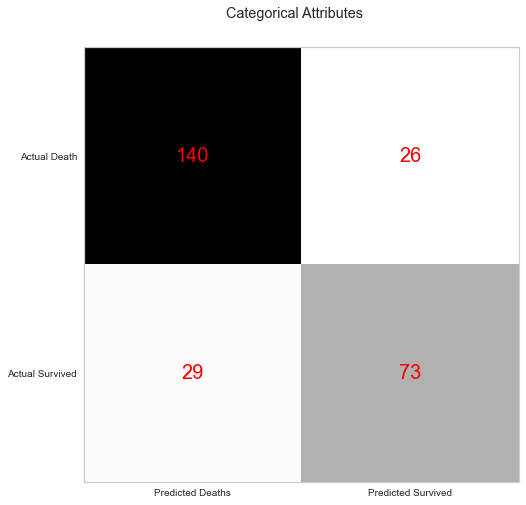

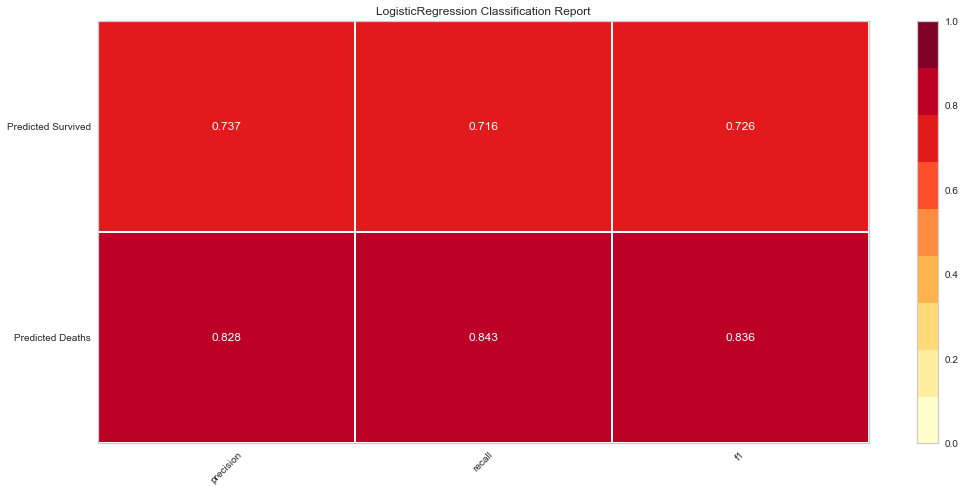

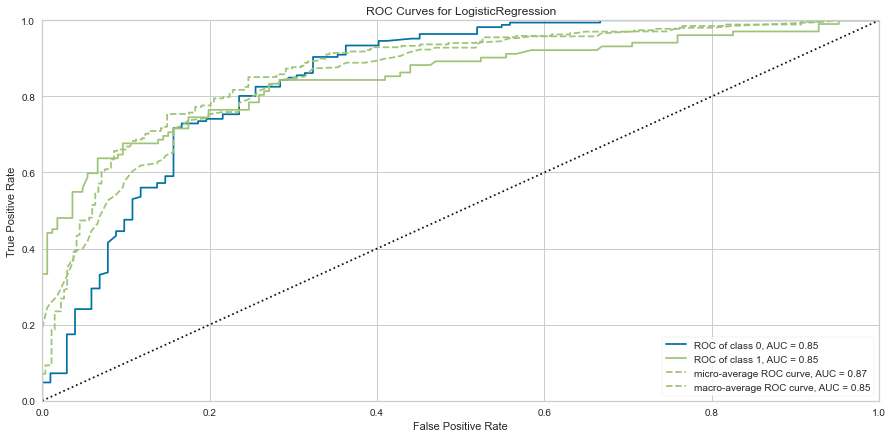

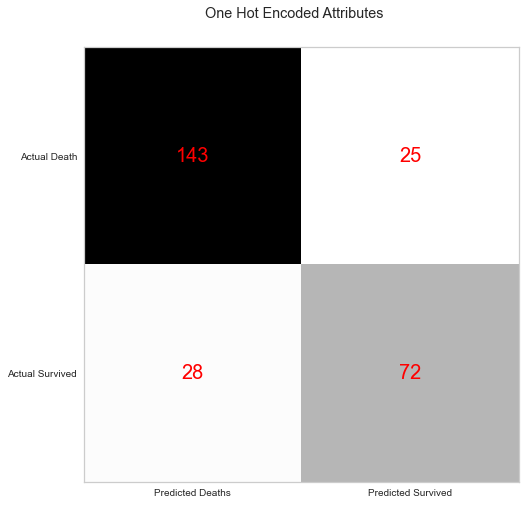

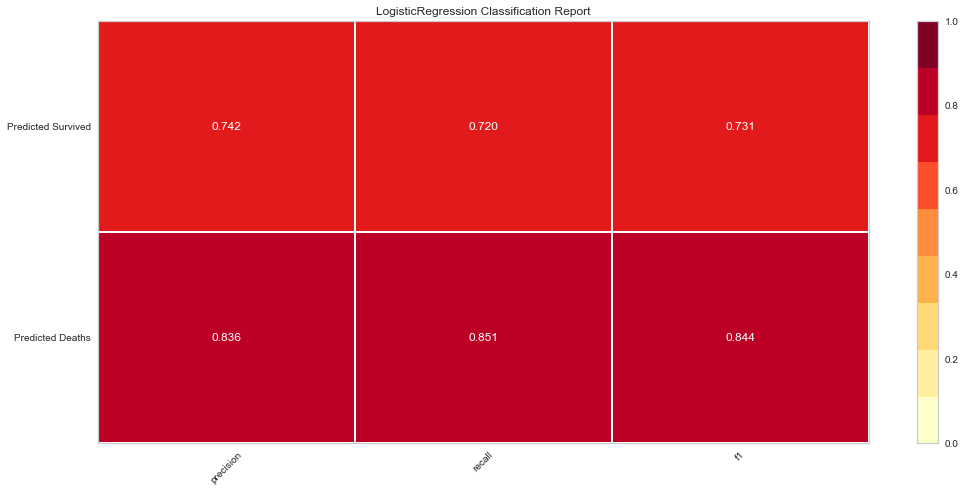

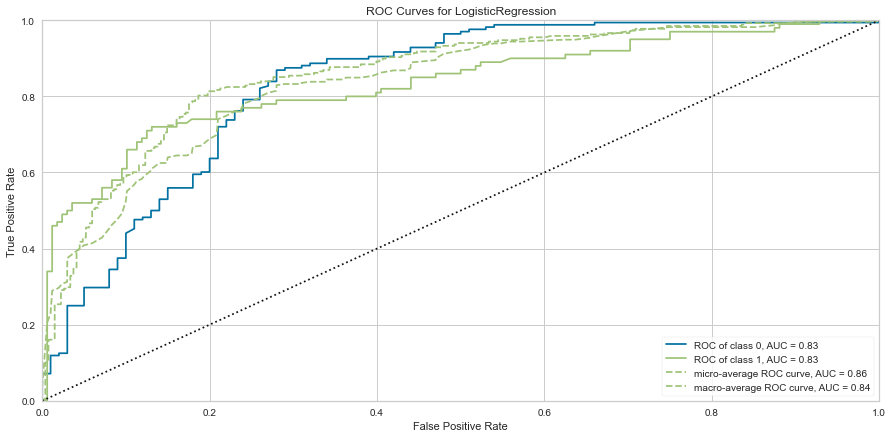

In [143]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

#//*** https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn
for model_type in ['cat','hot']:
    if model_type == 'cat':
        model = representative_categorical_model_df['models']
        x_train = representative_categorical_model_df['x_train']
        y_train = representative_categorical_model_df['y_train']
        x_test = representative_categorical_model_df['x_test']
        y_test = representative_categorical_model_df['y_test']
    elif model_type == 'hot':
        model = representative_one_hot_model_df['models']
        x_train = representative_one_hot_model_df['x_train']
        y_train = representative_one_hot_model_df['y_train']
        x_test = representative_one_hot_model_df['x_test']
        y_test = representative_one_hot_model_df['y_test']
        
    cm = confusion_matrix(y_test,model.predict(x_test))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Deaths', 'Predicted Survived'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Death', 'Actual Survived'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red',fontsize=20)
    if model_type == 'cat':
        plt.suptitle("Categorical Attributes",y=.95)
    elif model_type == 'hot':
        plt.suptitle("One Hot Encoded Attributes",y=.95)

    plt.show()
    
    classes = ['Predicted Deaths', 'Predicted Survived']
    # Instantiate the visualizer
    visualizer = ClassificationReport(model, classes=classes)

    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()

    # ROC and AUC
    #Instantiate the visualizer
    visualizer = ROCAUC(model)
    #y_train = y_train.replace('Survived',1).replace('Not_survived','0').astype(int)
    #y_val = y_val.replace('Survived',1).replace('Not_survived','0').astype(int)

    #print(y_train.unique())
    #print(y_val.unique())
    visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer

    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()
